# <span style="color:red"> Main Modelling - Logistic Regression - Gridsearch </span>

## dropping 'A Wild Sheep Chase'
* read in pickle v02
* keep 3 translators
* try different feature sets and save model each time
* compare results at the end
* all features available ie normalised counts and pos counts with some drops plus unique words, adj, adv

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textacy
import re
import pickle
import os

from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import label_binarize

import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 3))

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# extend limit of number of rows and columns to display in cell
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

### Load the dataframe containing text chunks and related variables

In [41]:
in_full_path = '../../../Documents/murakami/pkl3/df_all_v02.pkl'
# read back pickle
with open (in_full_path, 'rb') as fp:
    df = pickle.load(fp)

### Check the dataframe is as expected

In [42]:
df.head(1)

,book_chunk_no,number,title,text,fstop_indices,split_indices,chunks,translator,book_title,parsed,n_sents,n_words,n_chars,n_syllables,n_unique_words,n_long_words,n_monosyllable_words,n_polysyllable_words,trans_code,chunk_length,n_sents_norm,n_words_norm,n_chars_norm,n_syllables_norm,n_unique_words_norm,n_long_words_norm,n_monosyllable_words_norm,n_polysyllable_words_norm,vader_compound,vader_neg,vader_neu,vader_pos,pron_count,verb_count,det_count,adj_count,num_count,punct_count,noun_count,adp_count,cconj_count,sconj_count,adv_count,aux_count,part_count,propn_count,space_count,intj_count,sym_count,x_count,...,where_adv,too_adv,now_adv,all_adv,then_adv,just_adv,really_adv,there_adv,only_adv,even_adv,as_adv,always_adv,when_adv,again_adv,here_adv,maybe_adv,still_adv,back_adv,why_adv,very_adv,never_adv,how_adv,whole_adj,small_adj,long_adj,able_adj,more_adj,sure_adj,big_adj,last_adj,bad_adj,old_adj,same_adj,good_adj,new_adj,only_adj,different_adj,other_adj,next_adj,few_adj,much_adj,hard_adj,real_adj,young_adj,own_adj,first_adj,deep_adj,strange_adj,little_adj,right_adj
0,0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",IT WAS A short one-paragraph item in the morni...,Alfred Birnbaum,A Wild Sheep Chase,"(IT, WAS, A, short, one, -, paragraph, item, i...",15,174,742,240,116,33,128,17,0,944,15.889831,184.322034,786.016949,254.237288,122.881356,34.957627,135.59322,18.008475,-0.4798,0.075,0.862,0.064,18.0,20.0,31.0,9.0,2.0,33.0,51.0,19.0,6.0,3.0,5.0,5.0,3.0,2.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
df.shape

(5253, 141)

In [44]:
df.book_title.unique()

array(['A Wild Sheep Chase', 'Kafka On The Shore',
       'Colorless Tsukuru Tazaki', 'The Elephant Vanishes',
       'The Wind Up Bird Chronicle', 'Norwegian Wood',
       'Dance Dance Dance'], dtype=object)

In [45]:
df = df[df['book_title'] != 'A Wild Sheep Chase']

In [46]:
df.book_title.unique()

array(['Kafka On The Shore', 'Colorless Tsukuru Tazaki',
       'The Elephant Vanishes', 'The Wind Up Bird Chronicle',
       'Norwegian Wood', 'Dance Dance Dance'], dtype=object)

In [47]:
df.columns

Index(['book_chunk_no', 'number', 'title', 'text', 'fstop_indices',
       'split_indices', 'chunks', 'translator', 'book_title', 'parsed',
       ...
       'much_adj', 'hard_adj', 'real_adj', 'young_adj', 'own_adj', 'first_adj',
       'deep_adj', 'strange_adj', 'little_adj', 'right_adj'],
      dtype='object', length=141)

### Check the baseline

In [48]:
baseline_acc = df['trans_code'].value_counts(normalize=True).max()
baseline_acc

0.4364282726892514

### Set initial Predictor Variables
* Choose normalised count variables from textacy, ntlk dropping some suspicious ones
* not using vader sentiment scores

In [49]:
df.columns[20:60]

Index(['n_sents_norm', 'n_words_norm', 'n_chars_norm', 'n_syllables_norm',
       'n_unique_words_norm', 'n_long_words_norm', 'n_monosyllable_words_norm',
       'n_polysyllable_words_norm', 'vader_compound', 'vader_neg', 'vader_neu',
       'vader_pos', 'pron_count', 'verb_count', 'det_count', 'adj_count',
       'num_count', 'punct_count', 'noun_count', 'adp_count', 'cconj_count',
       'sconj_count', 'adv_count', 'aux_count', 'part_count', 'propn_count',
       'space_count', 'intj_count', 'sym_count', 'x_count', 'pron_count_norm',
       'verb_count_norm', 'det_count_norm', 'adj_count_norm', 'num_count_norm',
       'punct_count_norm', 'noun_count_norm', 'adp_count_norm',
       'cconj_count_norm', 'sconj_count_norm'],
      dtype='object')

## Features = Basic Counts

### Choose features to include in modelling

In [50]:
def feature_select(basic_counts=True, vader=False, pos_counts=False, 
                   words=False, adv=False, adj=False):
    '''create column list depending on features to include in the modelling'''
    columns = []
    if basic_counts:
        columns += [i for i in df.columns if i.startswith('n_') & i.endswith('_norm')]
    if vader:
        columns += [i for i in df.columns if i.startswith('vader_')]
    if pos_counts:
        columns += [i for i in df.columns if i.endswith('_count_norm')]
    if words:
        columns += [i for i in df.columns if i.endswith('_w')]
    if adj:
        columns += [i for i in df.columns if i.endswith('_adj')]
    if adv:
        columns += [i for i in df.columns if i.endswith('_adv')]
    return columns

In [51]:
predictor_cols = feature_select()

### Drop some columns which may be linked to page formatting

In [52]:
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm']

In [53]:
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]

In [54]:
# predictor_cols

### Set Target and Predictor variables

In [55]:
X = df[predictor_cols]
y = df['trans_code']

### Make Train Test Split with stratify on y

In [56]:
# stratify based on your target variable
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1)

### Standardise the predictor variables

In [57]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

###  Gridsearch Logistic Regression 

In [58]:
def lr_mc_gridsearch(X_train, y_train):
    # set model
    model = LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=1000)
    # set typical grid search parameters
#     params = {'C': np.logspace(-4, 4, 10),
#           'penalty': ['l1', 'l2'],
#           'fit_intercept': [True, False]}
    params = {'C': [0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2']}

    # instantiate model
    model_gs = GridSearchCV(estimator=model,
                  param_grid=params,
                  cv=5,
                  scoring='accuracy',
                  return_train_score=True)
    # fit the model
    model_gs.fit(X_train, y_train)
    return model_gs

In [59]:
def lr_gridsearch_score(model, X_train, y_train, X_test, y_test):
    
    # print the grid search results
    results_dict = {}
    print('Best Parameters:')
    print(model.best_params_)
    print('Best estimator mean cross validated training score:')
    print(model.best_score_)
    print('Best estimator score on the full training set:')
    print(model.score(X_train, y_train))
    print('Best estimator score on the test set:')
    print(model.score(X_test, y_test))
    print('ROC-AUC score on the test set:')
    
    # store the grid search results as a dictionary
    y_bin = label_binarize(y_test, model.classes_)
    for i, class_ in enumerate(model.classes_):
        print('Class {}:'.format(class_), round(roc_auc_score(y_bin[:,i],model.predict_proba(X_test)[:,i]),2))
    results_dict['Best_Parameters'] = model.best_params_
    results_dict['Best_CV_Score'] = model.best_score_
    results_dict['Best_Train_Score'] = model.score(X_train, y_train)
    results_dict['Best_Test_Score'] = model.score(X_test, y_test)
    results_dict['AUC_Class_0'] = roc_auc_score(y_bin[:,0],model.predict_proba(X_test)[:,0])
    results_dict['AUC_Class_1'] = roc_auc_score(y_bin[:,1],model.predict_proba(X_test)[:,1])
    results_dict['AUC_Class_2'] = roc_auc_score(y_bin[:,2],model.predict_proba(X_test)[:,2])
    predictions = model.predict(X_test)
    results_dict['conmat'] = confusion_matrix(
        y_test, predictions, labels=[0, 1, 2])

    return results_dict

In [60]:
lreg_gs_01 = lr_mc_gridsearch(X_train, y_train)

In [61]:
lreg_gs_01_results = lr_gridsearch_score(lreg_gs_01, X_train, y_train, X_test, y_test)

Best Parameters:
{'C': 10, 'penalty': 'l2'}
Best estimator mean cross validated training score:
0.541437908496732
Best estimator score on the full training set:
0.5406535947712419
Best estimator score on the test set:
0.5590386624869383
ROC-AUC score on the test set:
Class 0: 0.76
Class 1: 0.78
Class 2: 0.61


In [62]:
lreg_gs_01_results

{'Best_Parameters': {'C': 10, 'penalty': 'l2'},
 'Best_CV_Score': 0.541437908496732,
 'Best_Train_Score': 0.5406535947712419,
 'Best_Test_Score': 0.5590386624869383,
 'AUC_Class_0': 0.7551596411263044,
 'AUC_Class_1': 0.7809074042840276,
 'AUC_Class_2': 0.6135473478068606,
 'conmat': array([[125,  97,  36],
        [ 41, 356,  21],
        [ 75, 152,  54]])}

#### There is a very slight improvement over the basic logistic regression - optimizing parameters with gridsearch does not improve accuracy significantly

### Save the model

In [63]:
# set the output path and name
out_path = '../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_01_ns'
out_full_path = out_path + out_name + '.pkl'

# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(lreg_gs_01, fp)

## Features = Basic Counts + POS Counts

In [64]:
predictor_cols = feature_select(basic_counts=True, pos_counts=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]

X = df[predictor_cols]
y = df['trans_code']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

lreg_gs_02 = lr_mc_gridsearch(X_train, y_train)

lreg_gs_02_results = lr_gridsearch_score(lreg_gs_02, X_train, y_train, X_test, y_test)

Best Parameters:
{'C': 0.1, 'penalty': 'l2'}
Best estimator mean cross validated training score:
0.6073202614379085
Best estimator score on the full training set:
0.6130718954248366
Best estimator score on the test set:
0.5945663531870429
ROC-AUC score on the test set:
Class 0: 0.78
Class 1: 0.81
Class 2: 0.71


In [65]:
lreg_gs_02_results

{'Best_Parameters': {'C': 0.1, 'penalty': 'l2'},
 'Best_CV_Score': 0.6073202614379085,
 'Best_Train_Score': 0.6130718954248366,
 'Best_Test_Score': 0.5945663531870429,
 'AUC_Class_0': 0.7812156901886416,
 'AUC_Class_1': 0.8096022227942937,
 'AUC_Class_2': 0.7120701636168375,
 'conmat': array([[116,  86,  56],
        [ 38, 340,  40],
        [ 50, 118, 113]])}

In [66]:
# set the output path and name
out_path = '../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_02_ns'
out_full_path = out_path + out_name + '.pkl'

# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(lreg_gs_02, fp)

## Features = Basic Counts + POS Counts + words

In [67]:
predictor_cols = feature_select(basic_counts=True, pos_counts=True, words=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]

X = df[predictor_cols]
y = df['trans_code']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

lreg_gs_03 = lr_mc_gridsearch(X_train, y_train)

lreg_gs_03_results = lr_gridsearch_score(lreg_gs_03, X_train, y_train, X_test, y_test)

Best Parameters:
{'C': 0.1, 'penalty': 'l2'}
Best estimator mean cross validated training score:
0.672156862745098
Best estimator score on the full training set:
0.6794771241830065
Best estimator score on the test set:
0.670846394984326
ROC-AUC score on the test set:
Class 0: 0.82
Class 1: 0.85
Class 2: 0.81


In [68]:
# set the output path and name
out_path = '../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_03_ns'
out_full_path = out_path + out_name + '.pkl'

# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(lreg_gs_03, fp)

## Features = Basic Counts + POS Counts + words + adj

In [69]:
predictor_cols = feature_select(basic_counts=True, pos_counts=True, words=True, adj=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]

X = df[predictor_cols]
y = df['trans_code']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

lreg_gs_04 = lr_mc_gridsearch(X_train, y_train)

lreg_gs_04_results = lr_gridsearch_score(lreg_gs_04, X_train, y_train, X_test, y_test)

Best Parameters:
{'C': 1, 'penalty': 'l1'}
Best estimator mean cross validated training score:
0.6828758169934641
Best estimator score on the full training set:
0.6998692810457516
Best estimator score on the test set:
0.6865203761755486
ROC-AUC score on the test set:
Class 0: 0.83
Class 1: 0.85
Class 2: 0.82


In [70]:
# set the output path and name
out_path = '../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_04_ns'
out_full_path = out_path + out_name + '.pkl'

# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(lreg_gs_04, fp)

## Features = Basic Counts + POS Counts + words + adj + adv

In [71]:
predictor_cols = feature_select(basic_counts=True, pos_counts=True, words=True, adj=True, adv=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]

X = df[predictor_cols]
y = df['trans_code']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

lreg_gs_05 = lr_mc_gridsearch(X_train, y_train)

lreg_gs_05_results = lr_gridsearch_score(lreg_gs_05, X_train, y_train, X_test, y_test)

Best Parameters:
{'C': 1, 'penalty': 'l1'}
Best estimator mean cross validated training score:
0.6943790849673203
Best estimator score on the full training set:
0.7192156862745098
Best estimator score on the test set:
0.7084639498432602
ROC-AUC score on the test set:
Class 0: 0.85
Class 1: 0.86
Class 2: 0.84


In [72]:
# set the output path and name
out_path = '../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_05_ns'
out_full_path = out_path + out_name + '.pkl'

# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(lreg_gs_05, fp)

## Features = Basic Counts + POS Counts + words + adj + adv + vader

In [73]:
predictor_cols = feature_select(basic_counts=True, pos_counts=True, vader=True, words=True, adj=True, adv=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]

X = df[predictor_cols]
y = df['trans_code']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

lreg_gs_06 = lr_mc_gridsearch(X_train, y_train)

lreg_gs_06_results = lr_gridsearch_score(lreg_gs_06, X_train, y_train, X_test, y_test)

Best Parameters:
{'C': 100, 'penalty': 'l2'}
Best estimator mean cross validated training score:
0.6943790849673203
Best estimator score on the full training set:
0.72
Best estimator score on the test set:
0.6948798328108673
ROC-AUC score on the test set:
Class 0: 0.85
Class 1: 0.86
Class 2: 0.84


In [74]:
# set the output path and name
out_path = '../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_06_ns'
out_full_path = out_path + out_name + '.pkl'

# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(lreg_gs_06, fp)

## Confusion Matrices

In [75]:
lreg_results = [lreg_gs_01_results,
                lreg_gs_02_results,
                lreg_gs_03_results,
                lreg_gs_04_results,
                lreg_gs_05_results,
                lreg_gs_06_results,]

In [76]:
lreg_gs_01_results['conmat']

array([[125,  97,  36],
       [ 41, 356,  21],
       [ 75, 152,  54]])

In [77]:
lreg_gs_02_results['conmat']

array([[116,  86,  56],
       [ 38, 340,  40],
       [ 50, 118, 113]])

In [78]:
for i, results in enumerate(lreg_results):
    print(i+1)
    print(pd.DataFrame(results['conmat'], index=['actual birnbaum', 'actual rubin', 'actual gabriel'],
                             columns=['predicted birnbaum', 'predicted rubin', 'predicted gabriel']))

1
                 predicted birnbaum  predicted rubin  predicted gabriel
actual birnbaum                 125               97                 36
actual rubin                     41              356                 21
actual gabriel                   75              152                 54
2
                 predicted birnbaum  predicted rubin  predicted gabriel
actual birnbaum                 116               86                 56
actual rubin                     38              340                 40
actual gabriel                   50              118                113
3
                 predicted birnbaum  predicted rubin  predicted gabriel
actual birnbaum                 140               62                 56
actual rubin                     34              333                 51
actual gabriel                   37               75                169
4
                 predicted birnbaum  predicted rubin  predicted gabriel
actual birnbaum                 142               65    

## Confusion Matrix Comments
* Model 1 - basic counts: does very well for Birnbaum and Rubin but very badly for Gabriel
* Model 2 - basic + POS counts: slight improvement for Birnbaum, a slight drop for Rubin. Gabriel is much improved but still the lowest accuracy
* Model 3 - basic + POS + word counts: Gabriel accuracy imrpoves significantly
* Model 4 - basic + POS + word counts + adj: no significant improvement on the test scores
* Model 5 - basic + POS + word counts + adj + adv: slight improvement across the board
* Model 6 - basic + POS + word counts + adj + adv + vader: no significant improvement on the test scores

## Classification Report
!!! to be set up!!!

In [79]:
# predictions = lreg_gs_01.predict(X_test)
# print(classification_report(y_test, predictions))

In [80]:
model_nums = []
cv_scores = []
train_scores = []
test_scores = []
auc_0 = []
auc_1 = []
auc_2 = []


for i, results in enumerate(lreg_results):
    model_nums.append(i+1)
    cv_scores.append(results['Best_CV_Score'])
    train_scores.append(results['Best_Train_Score'])
    test_scores.append(results['Best_Test_Score'])
    auc_0.append(results['AUC_Class_0'])
    auc_1.append(results['AUC_Class_1'])
    auc_2.append(results['AUC_Class_2'])

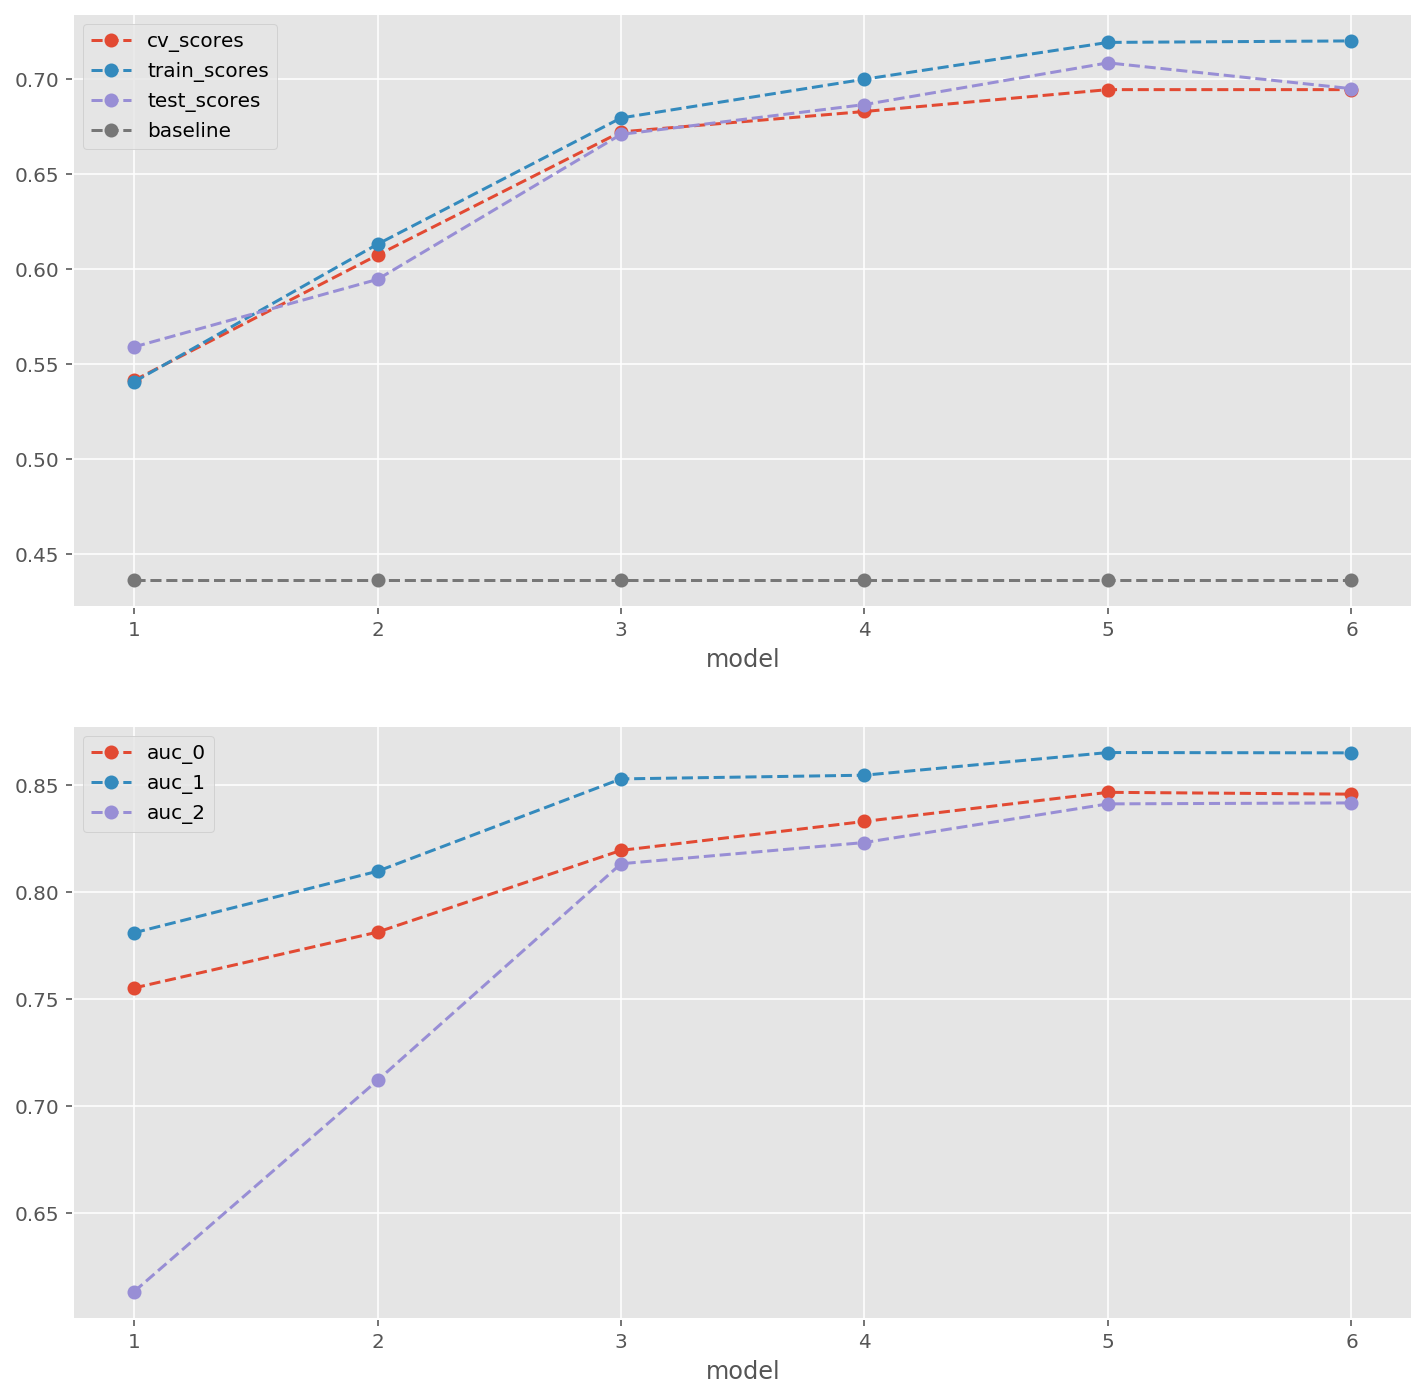

In [81]:
dict_cv_scores = {'model': model_nums, 
                  'cv_scores': cv_scores, 
                  'train_scores': train_scores,
                  'test_scores': test_scores,
                  'auc_0': auc_0,
                  'auc_1': auc_1,
                  'auc_2': auc_2,}
df_cv_scores = pd.DataFrame(dict_cv_scores)
df_cv_scores['baseline'] = baseline_acc

fig, ax = plt.subplots(nrows=2, figsize=(12,12))


df_cv_scores.sort_values(by='model').plot(x='model', y='cv_scores', linestyle='--', marker='o', ax=ax[0])
df_cv_scores.sort_values(by='model').plot(x='model', y='train_scores', linestyle='--', marker='o', ax=ax[0])
df_cv_scores.sort_values(by='model').plot(x='model', y='test_scores', linestyle='--', marker='o', ax=ax[0])
df_cv_scores.sort_values(by='model').plot(x='model', y='baseline', linestyle='--', marker='o', ax=ax[0])

df_cv_scores.sort_values(by='model').plot(x='model', y='auc_0', linestyle='--', marker='o', ax=ax[1])
df_cv_scores.sort_values(by='model').plot(x='model', y='auc_1', linestyle='--', marker='o', ax=ax[1])
df_cv_scores.sort_values(by='model').plot(x='model', y='auc_2', linestyle='--', marker='o', ax=ax[1])


plt.show()

In [82]:
predictor_cols = feature_select()
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(lreg_gs_01.best_estimator_.coef_, columns=predictor_cols,
                       index=['coefs_0', 'coefs_1', 'coefs_2']).T

In [83]:
df_coef

,coefs_0,coefs_1,coefs_2
n_sents_norm,1.208886,-1.454678,0.332179
n_words_norm,-2.000602,0.703655,1.306177
n_chars_norm,0.394181,-0.900549,0.467478
n_syllables_norm,0.768850,-0.342986,-0.387720
n_unique_words_norm,0.601231,-0.518353,0.062163
n_long_words_norm,0.320351,-0.112456,-0.102642
n_monosyllable_words_norm,1.794743,-0.452253,-1.292685
n_polysyllable_words_norm,-0.441408,0.266775,0.174559


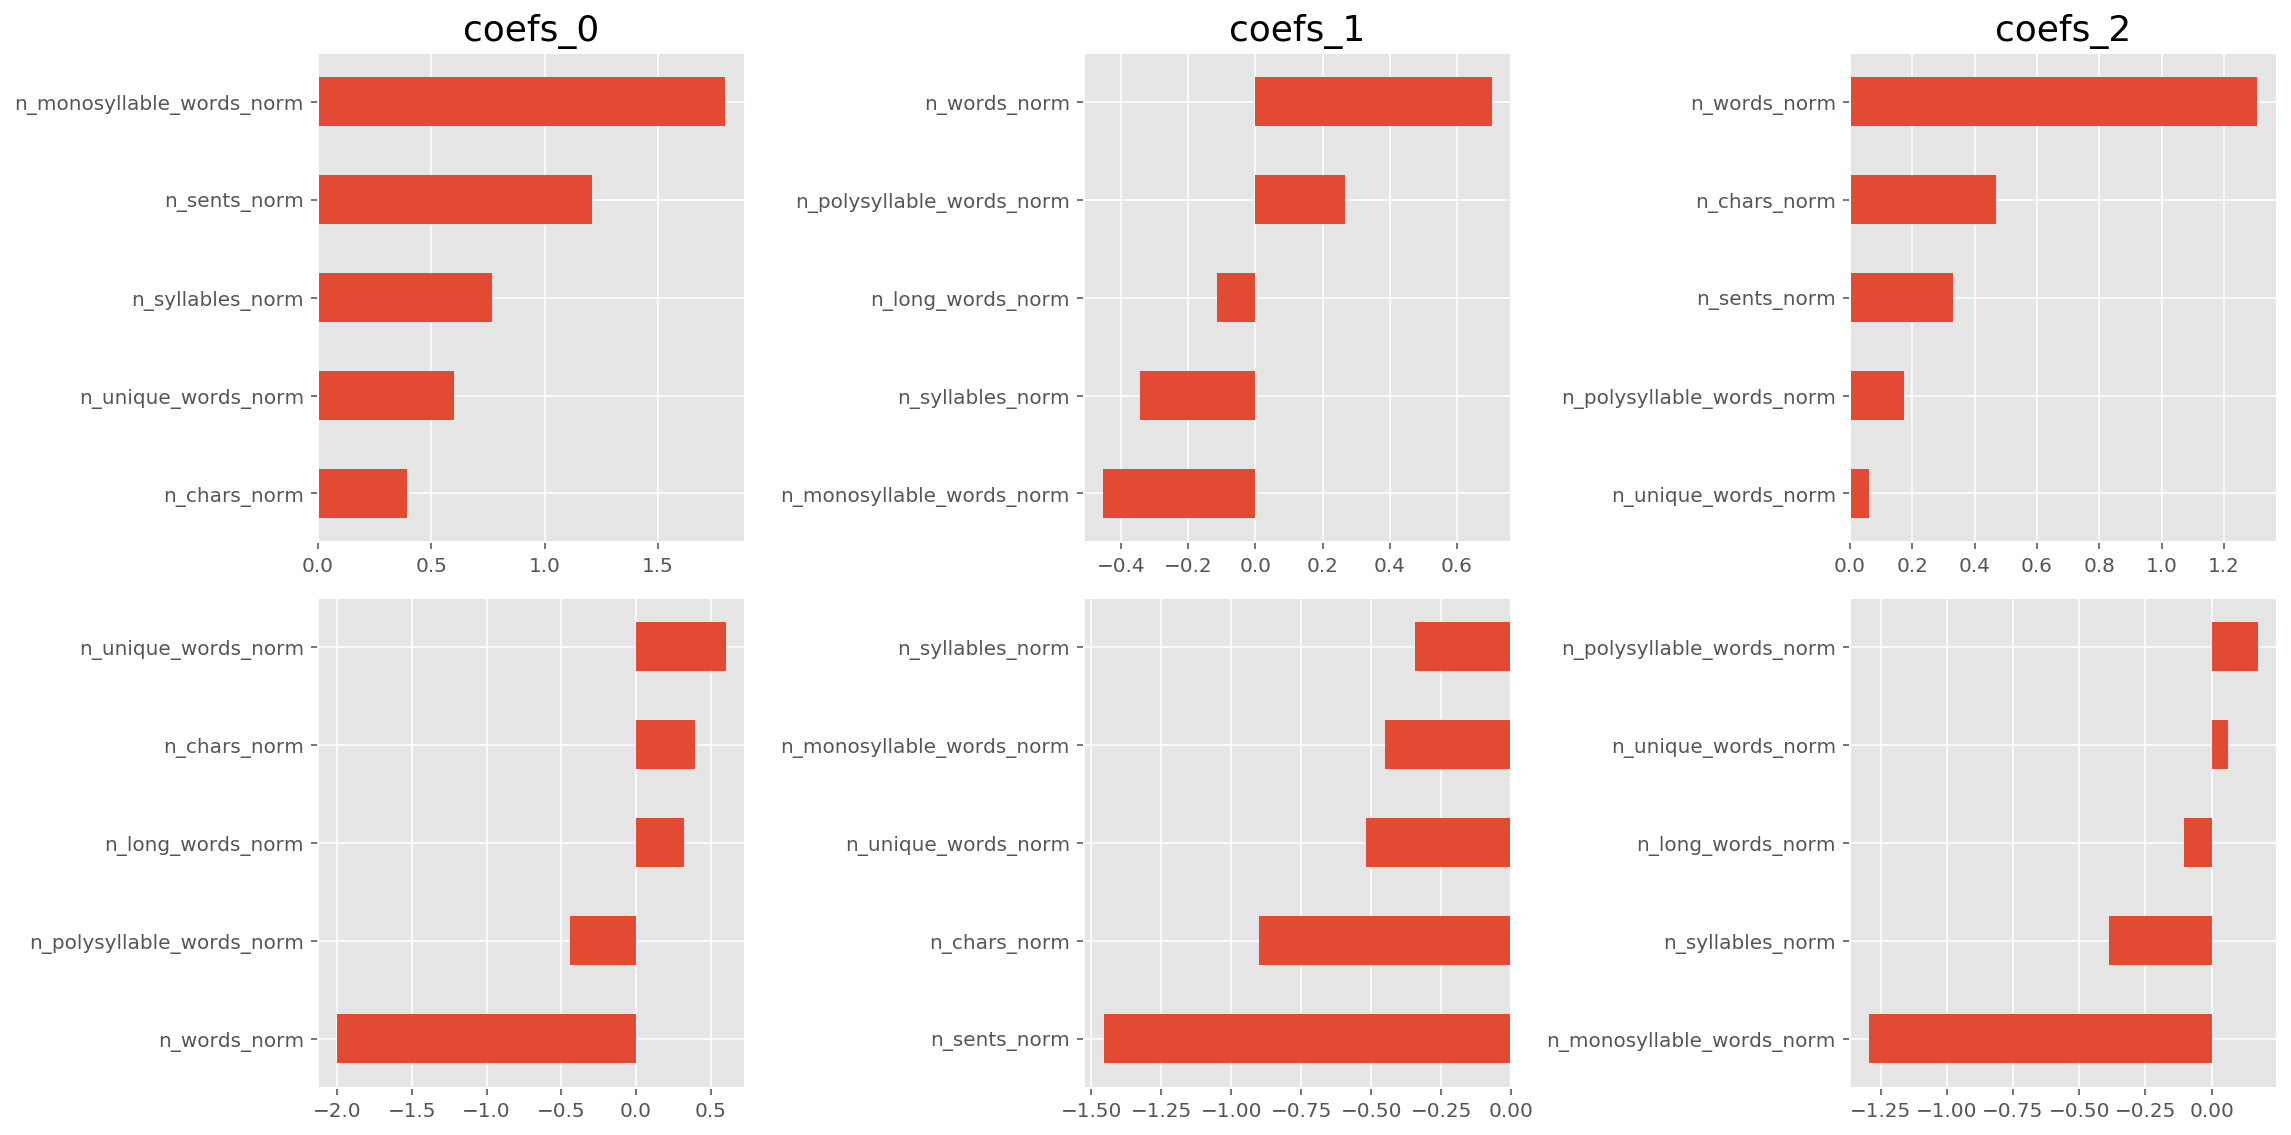

In [84]:
fig, ax = plt.subplots(nrows=2, ncols=len(df_coef.columns), figsize=(16, 8))
for i, col in enumerate(df_coef.columns):
    df_coef[col].sort_values(ascending=True).tail(5).plot(kind='barh', ax=ax[0,i])
    ax[0,i].set_title(str(col), fontsize=18)
    df_coef[col].sort_values(ascending=True).head(5).plot(kind='barh', ax=ax[1,i])
plt.tight_layout()
plt.show()

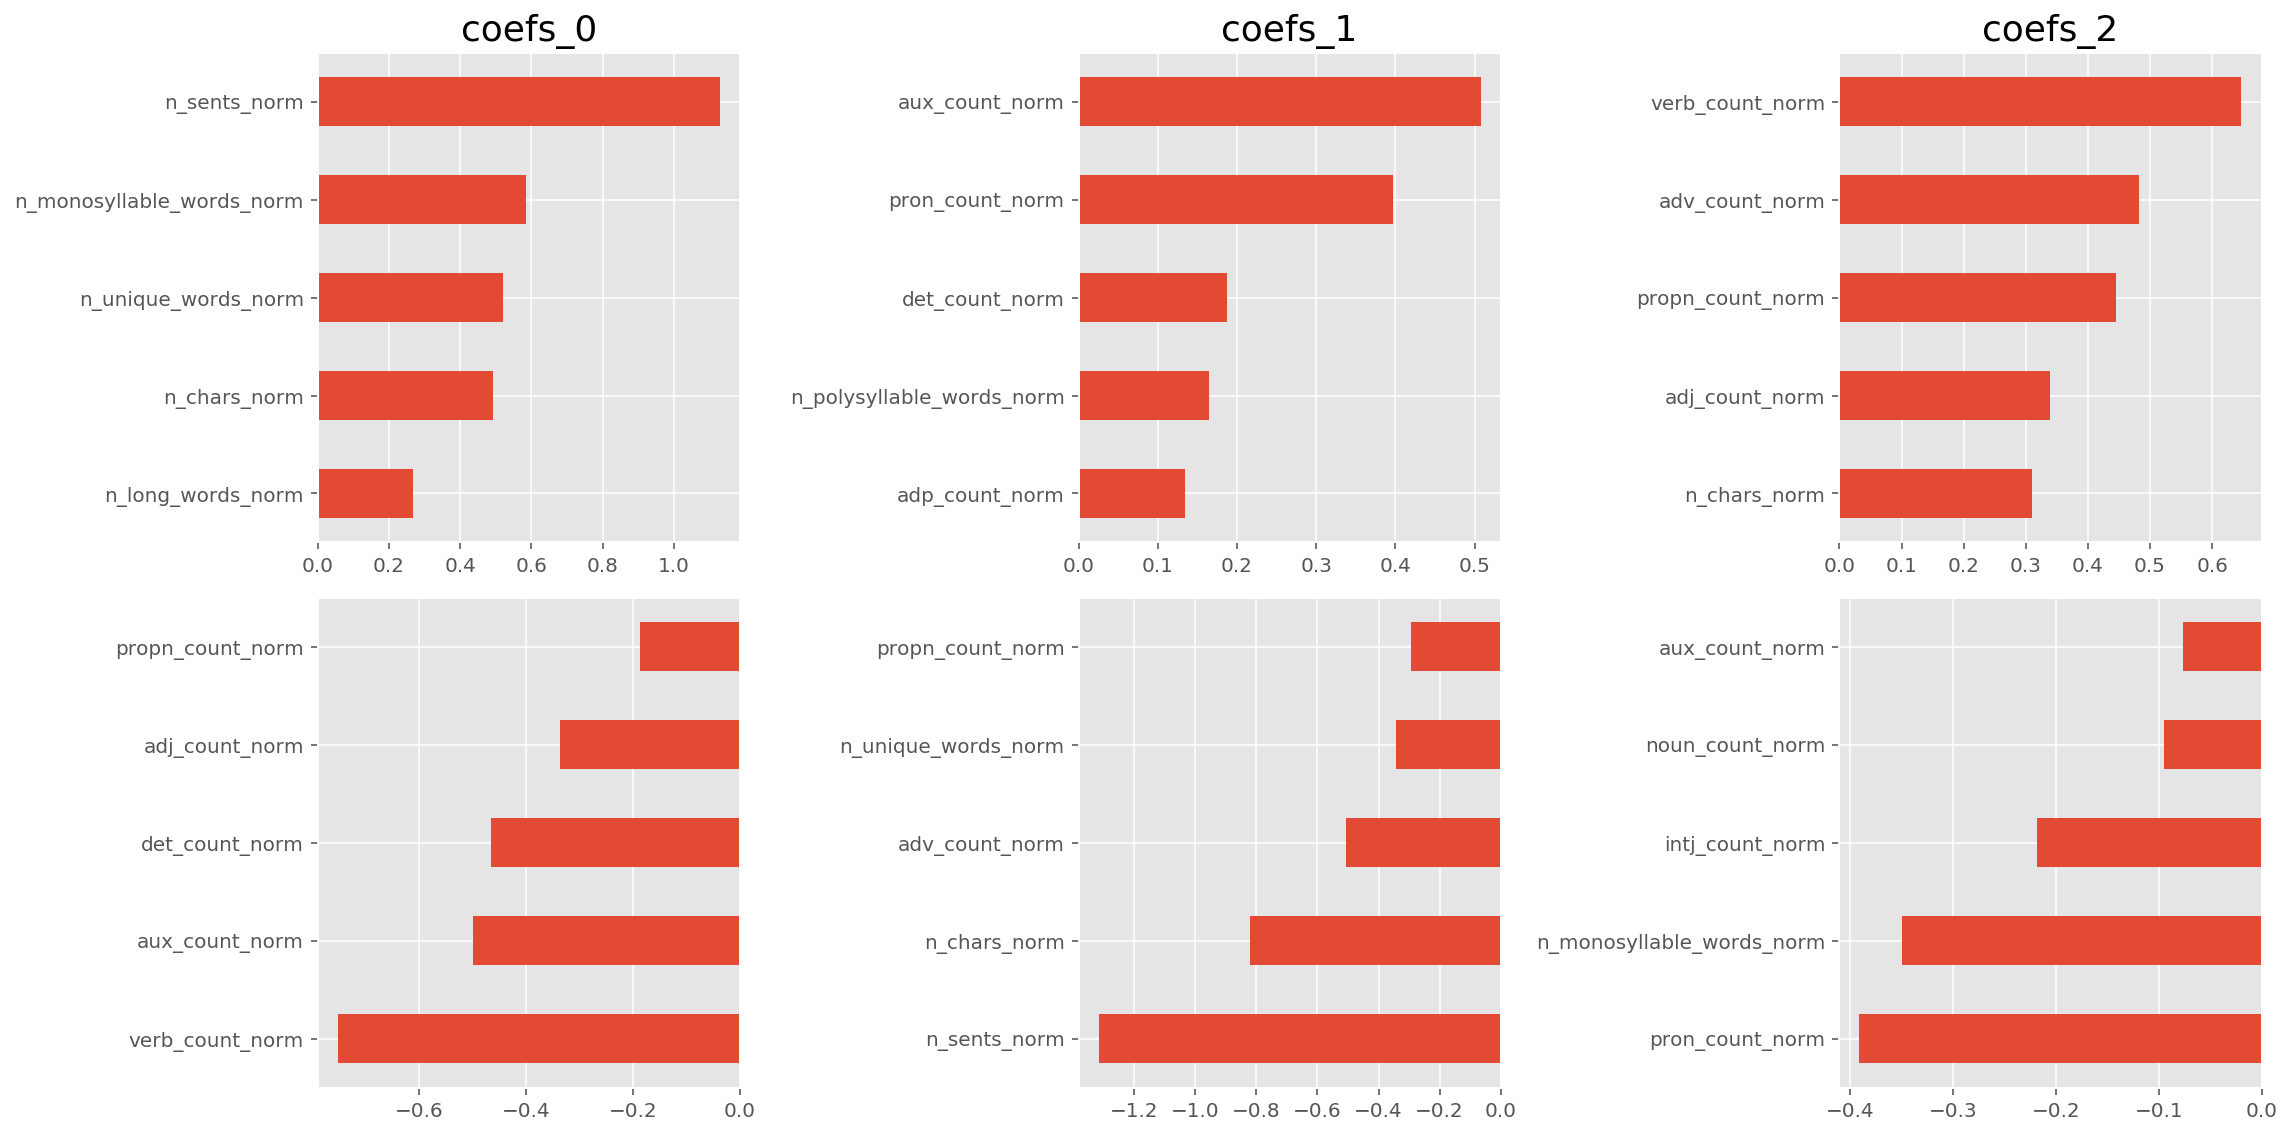

In [85]:
predictor_cols = feature_select(basic_counts=True, pos_counts=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(lreg_gs_02.best_estimator_.coef_, columns=predictor_cols,
                       index=['coefs_0', 'coefs_1', 'coefs_2']).T

fig, ax = plt.subplots(nrows=2, ncols=len(df_coef.columns), figsize=(16, 8))
for i, col in enumerate(df_coef.columns):
    df_coef[col].sort_values(ascending=True).tail(5).plot(kind='barh', ax=ax[0,i])
    ax[0,i].set_title(str(col), fontsize=18)
    df_coef[col].sort_values(ascending=True).head(5).plot(kind='barh', ax=ax[1,i])
plt.tight_layout()
plt.show()

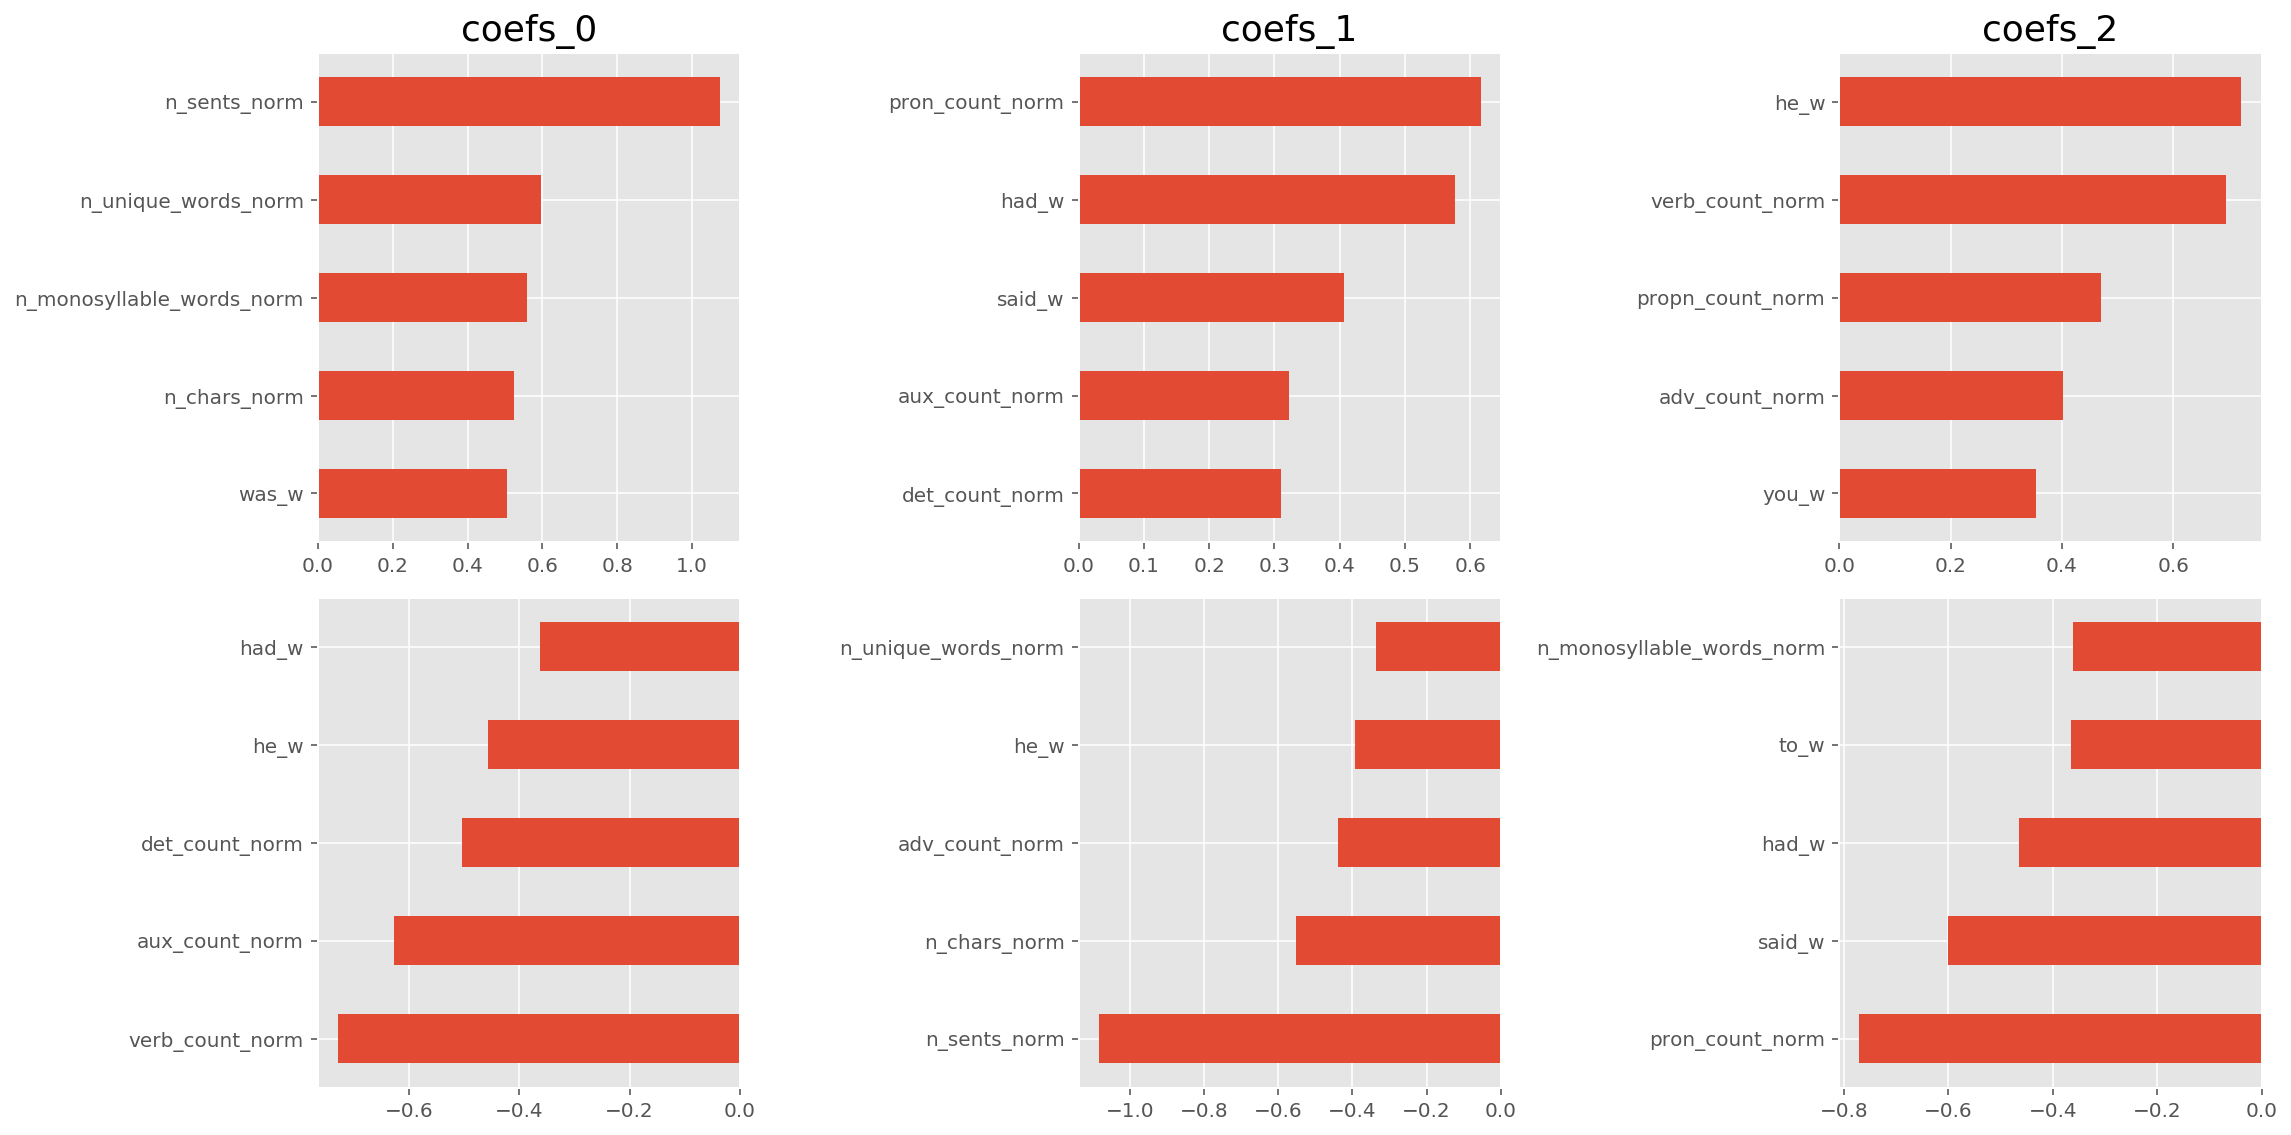

In [86]:
predictor_cols = feature_select(basic_counts=True, pos_counts=True, words=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(lreg_gs_03.best_estimator_.coef_, columns=predictor_cols,
                       index=['coefs_0', 'coefs_1', 'coefs_2']).T

fig, ax = plt.subplots(nrows=2, ncols=len(df_coef.columns), figsize=(16, 8))
for i, col in enumerate(df_coef.columns):
    df_coef[col].sort_values(ascending=True).tail(5).plot(kind='barh', ax=ax[0,i])
    ax[0,i].set_title(str(col), fontsize=18)
    df_coef[col].sort_values(ascending=True).head(5).plot(kind='barh', ax=ax[1,i])
plt.tight_layout()
plt.show()

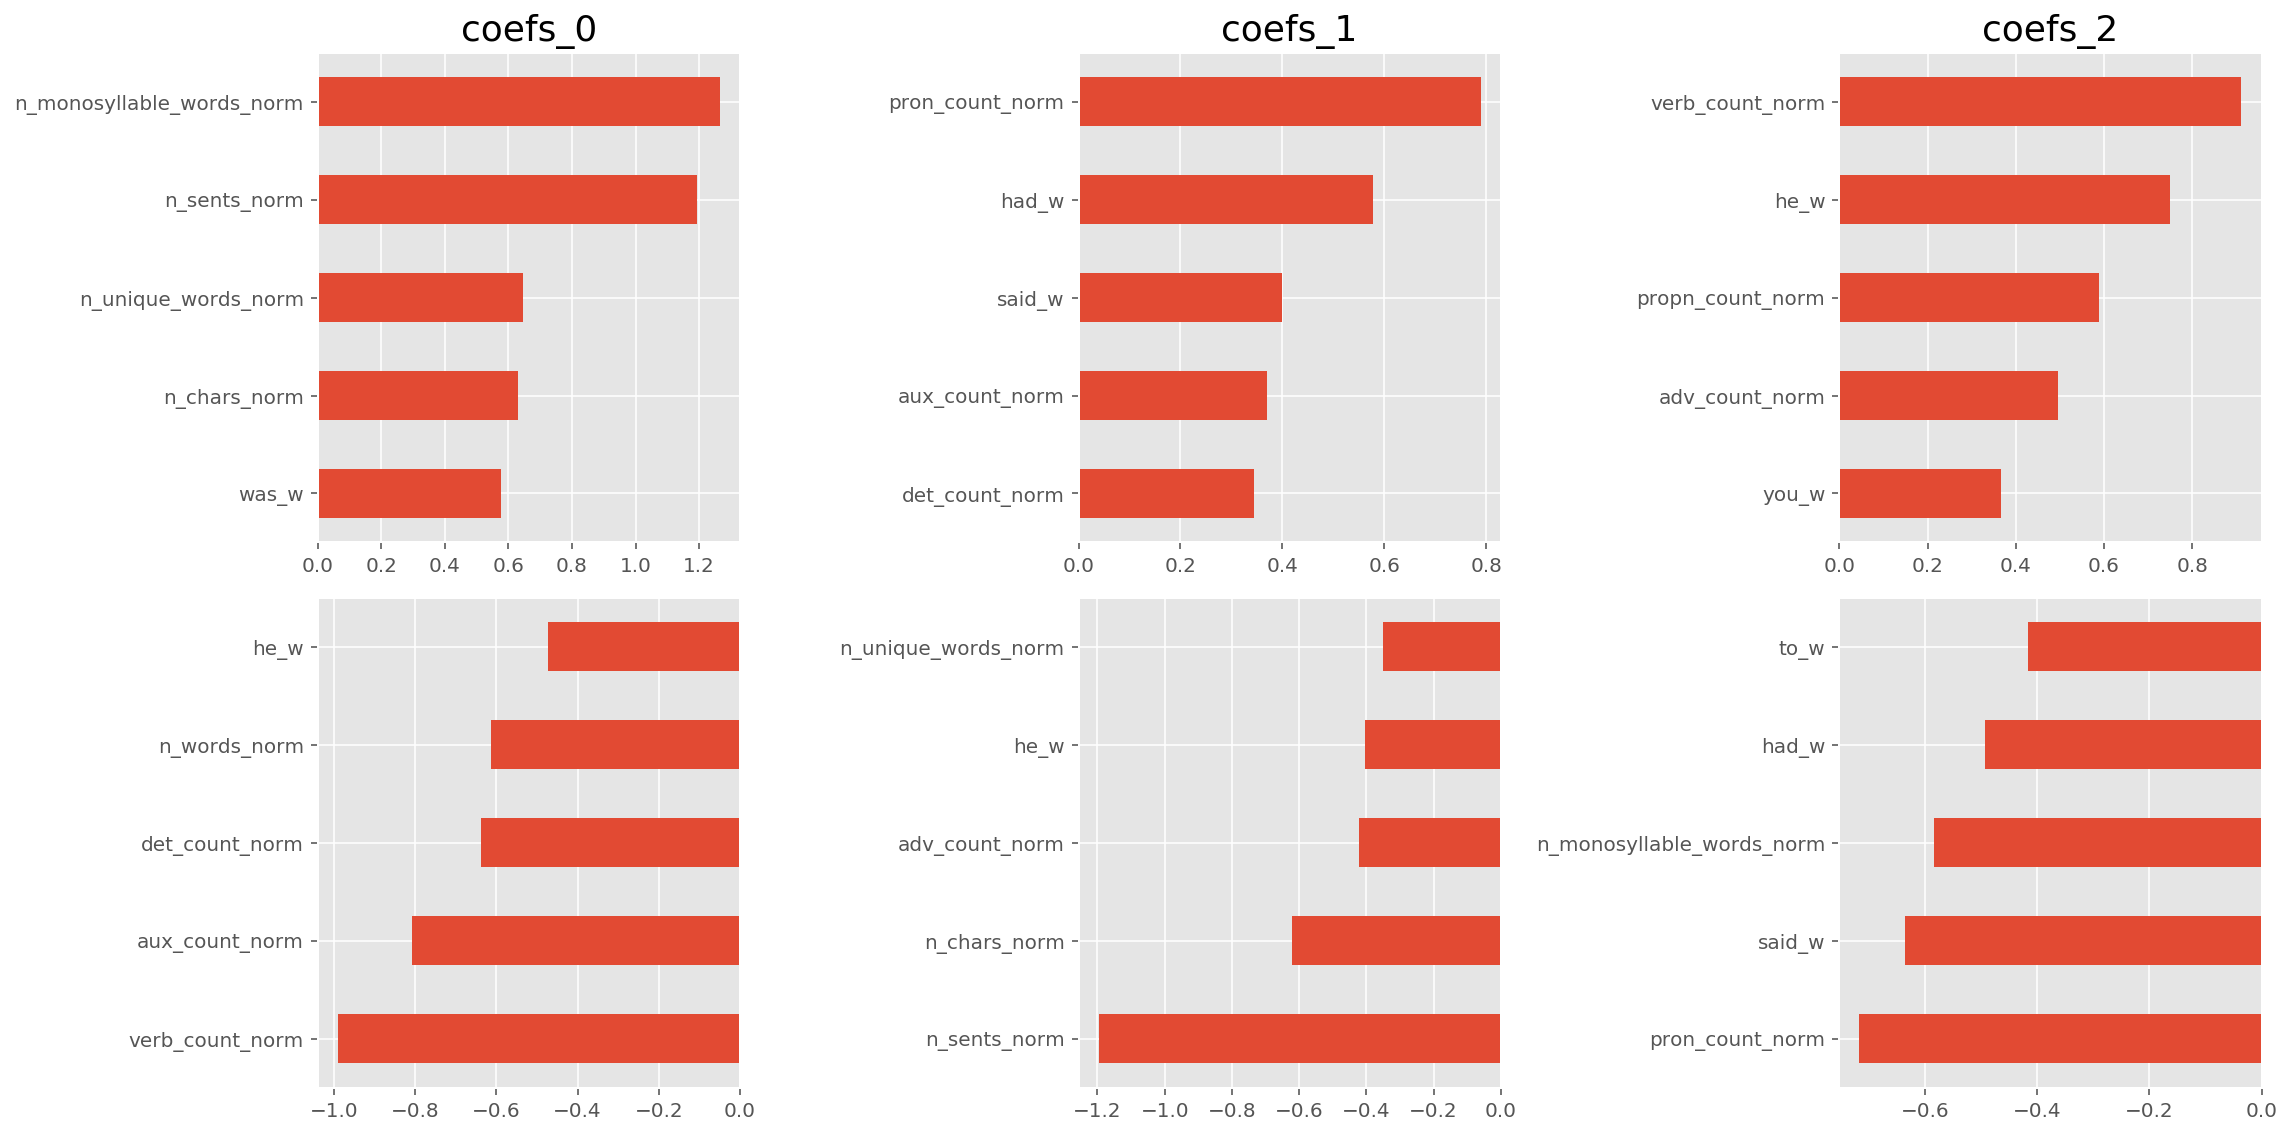

In [87]:
predictor_cols = feature_select(basic_counts=True, pos_counts=True, words=True, adj=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(lreg_gs_04.best_estimator_.coef_, columns=predictor_cols,
                       index=['coefs_0', 'coefs_1', 'coefs_2']).T

fig, ax = plt.subplots(nrows=2, ncols=len(df_coef.columns), figsize=(16, 8))
for i, col in enumerate(df_coef.columns):
    df_coef[col].sort_values(ascending=True).tail(5).plot(kind='barh', ax=ax[0,i])
    ax[0,i].set_title(str(col), fontsize=18)
    df_coef[col].sort_values(ascending=True).head(5).plot(kind='barh', ax=ax[1,i])
plt.tight_layout()
plt.show()


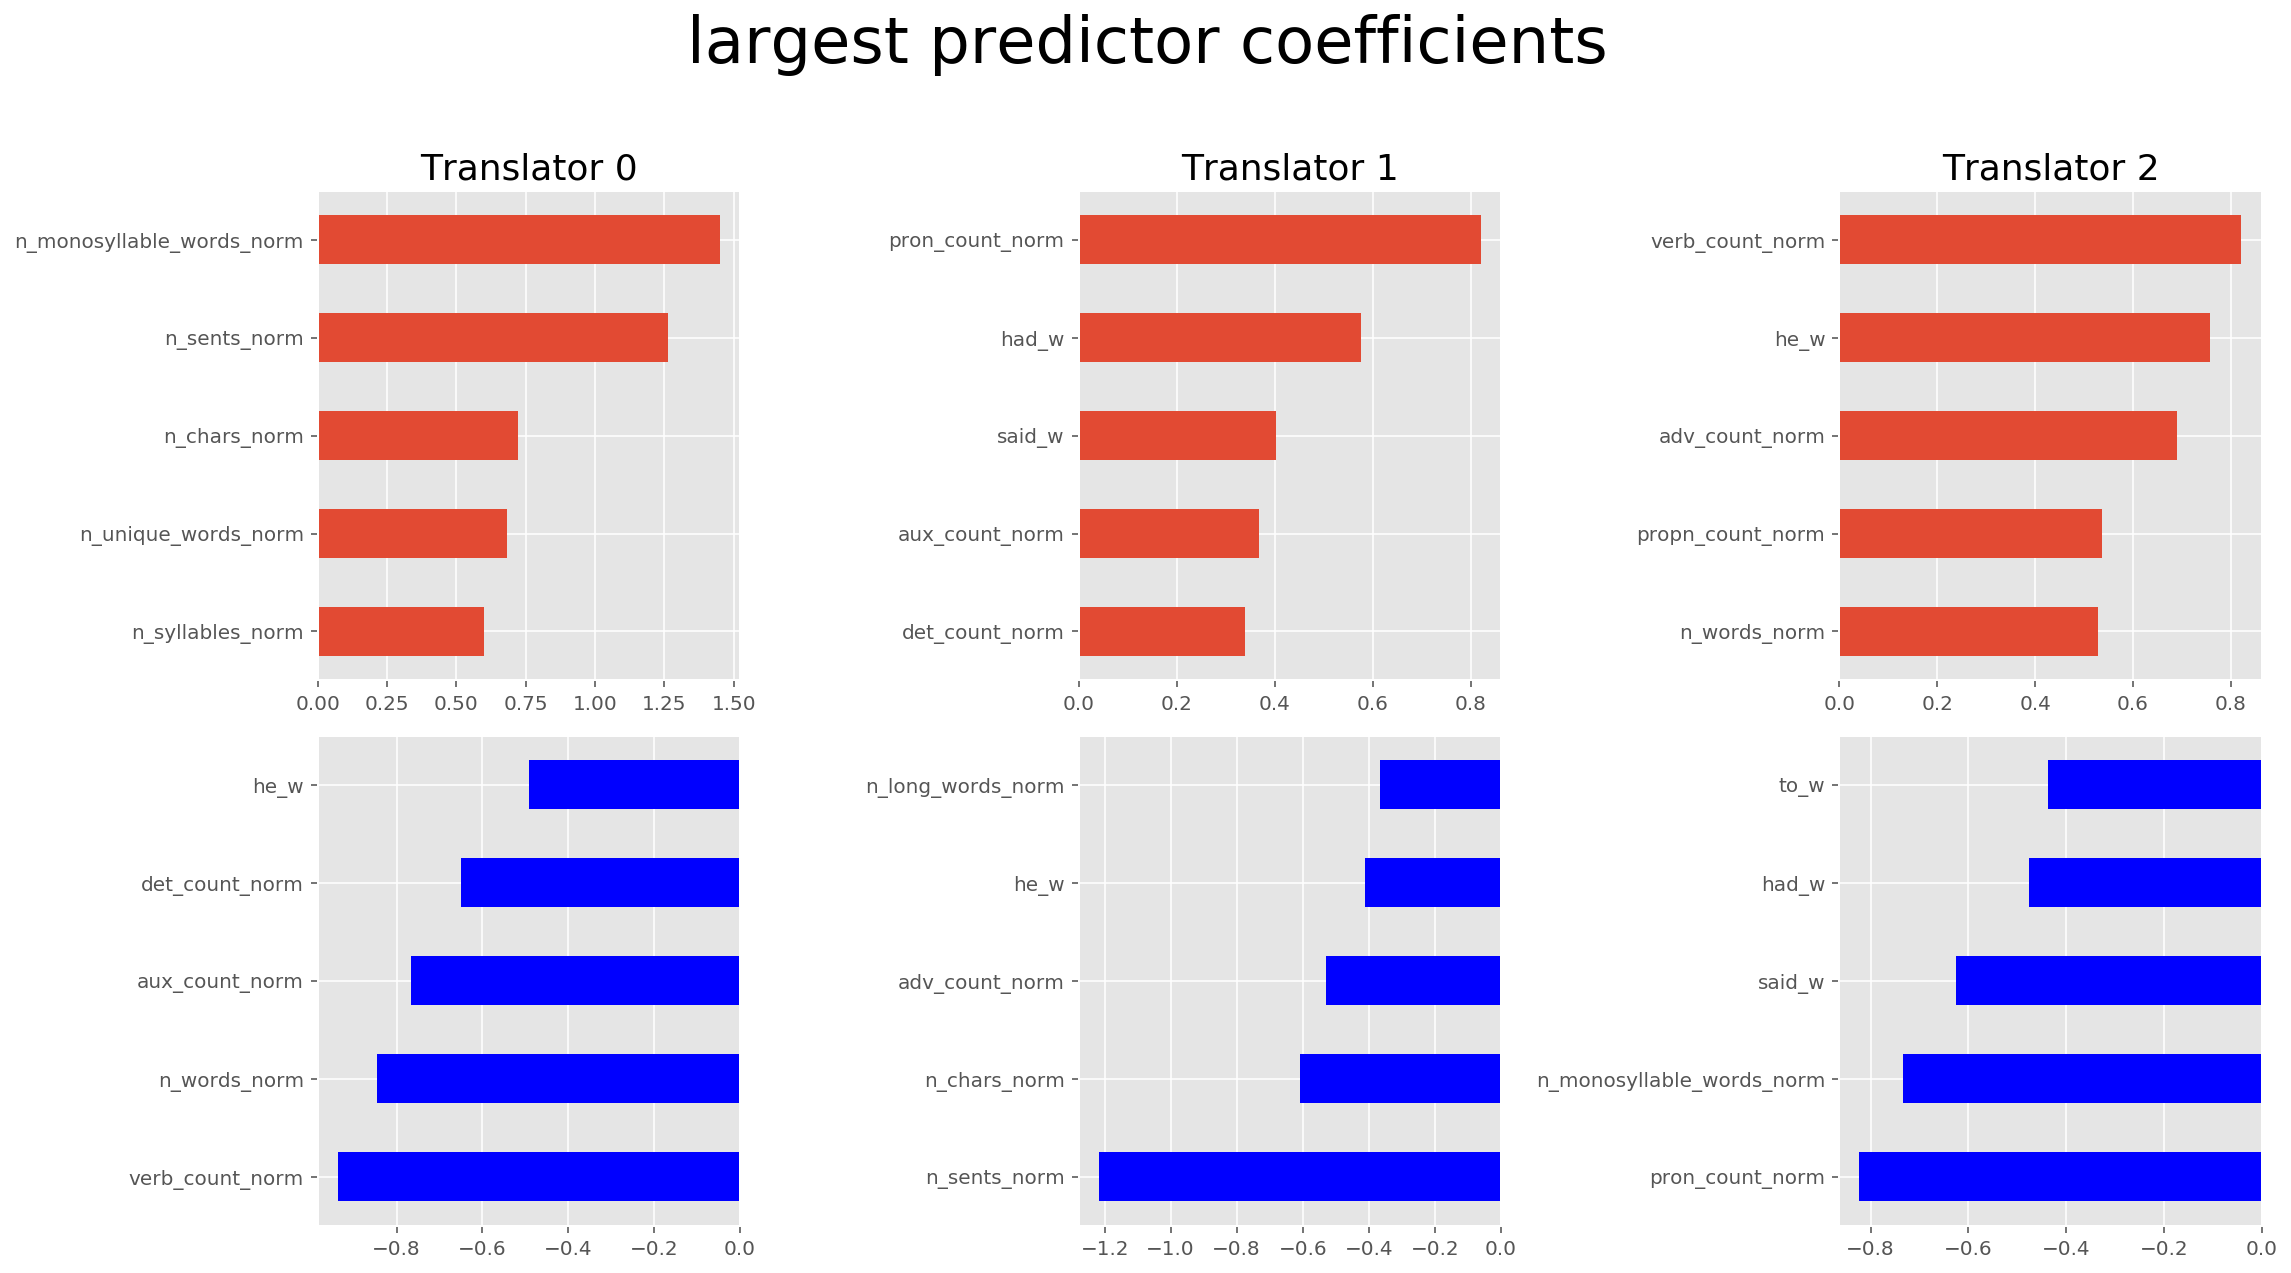

In [171]:
predictor_cols = feature_select(basic_counts=True, pos_counts=True, words=True, adj=True, adv=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(lreg_gs_05.best_estimator_.coef_, columns=predictor_cols,
                       index=['coefs_0', 'coefs_1', 'coefs_2']).T

fig, ax = plt.subplots(nrows=2, ncols=len(df_coef.columns), figsize=(16, 8))
for i, col in enumerate(df_coef.columns):
    df_coef[col].sort_values(ascending=True).tail(5).plot(kind='barh', ax=ax[0,i])
    ax[0,i].set_title('Translator ' + str(i), fontsize=18)
    df_coef[col].sort_values(ascending=True).head(5).plot(kind='barh', ax=ax[1,i], color='b')
fig.suptitle('largest predictor coefficients', fontsize=32, y=1.10)
plt.tight_layout()
plt.show()

In [172]:
# df_coef[col].sort_values(ascending=True)

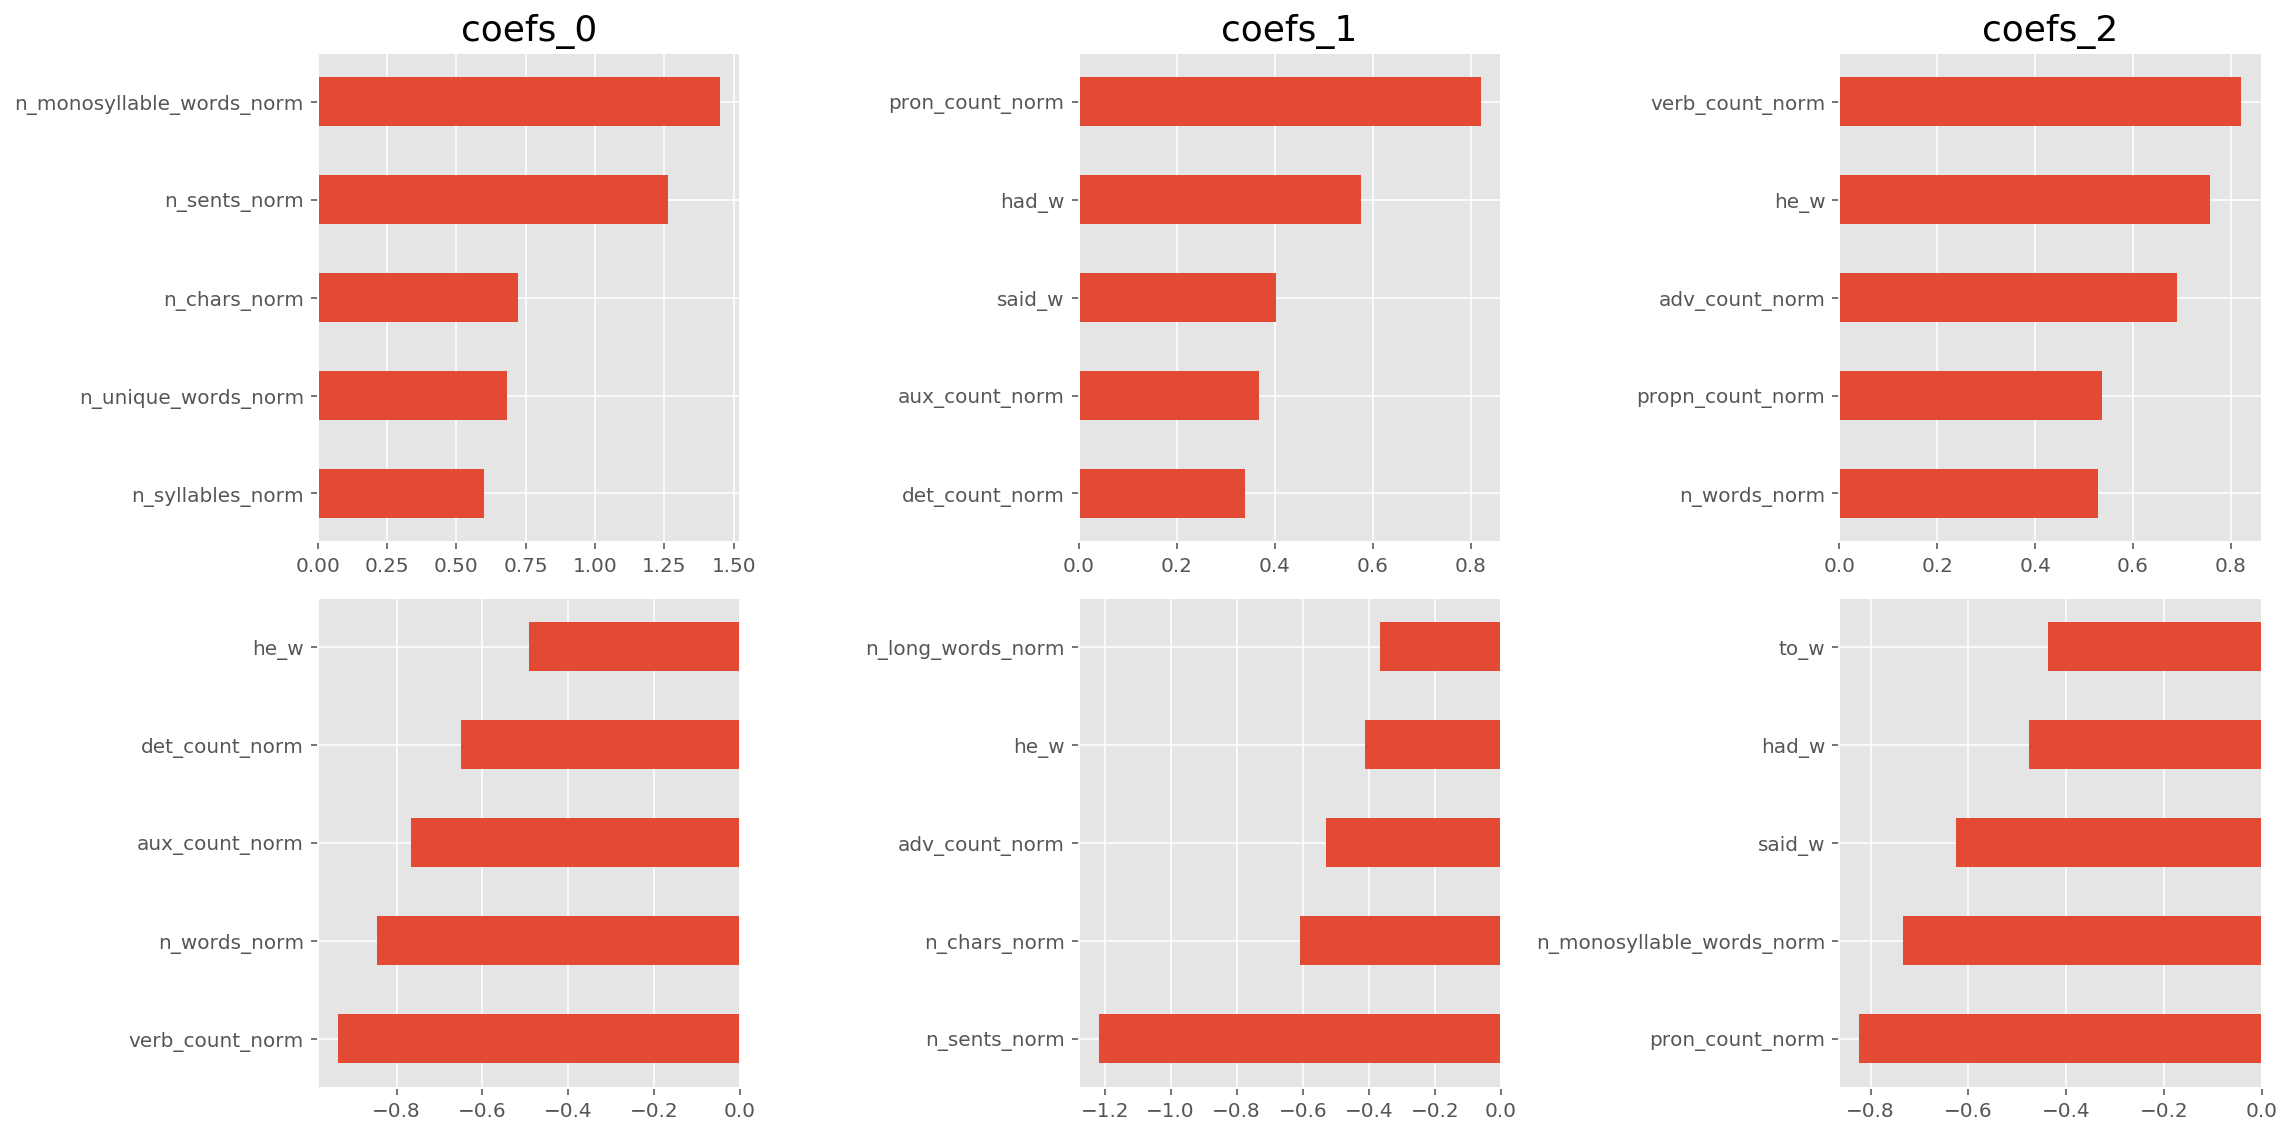

In [88]:
predictor_cols = feature_select(basic_counts=True, pos_counts=True, words=True, adj=True, adv=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(lreg_gs_05.best_estimator_.coef_, columns=predictor_cols,
                       index=['coefs_0', 'coefs_1', 'coefs_2']).T

fig, ax = plt.subplots(nrows=2, ncols=len(df_coef.columns), figsize=(16, 8))
for i, col in enumerate(df_coef.columns):
    df_coef[col].sort_values(ascending=True).tail(5).plot(kind='barh', ax=ax[0,i])
    ax[0,i].set_title(str(col), fontsize=18)
    df_coef[col].sort_values(ascending=True).head(5).plot(kind='barh', ax=ax[1,i])
plt.tight_layout()
plt.show()



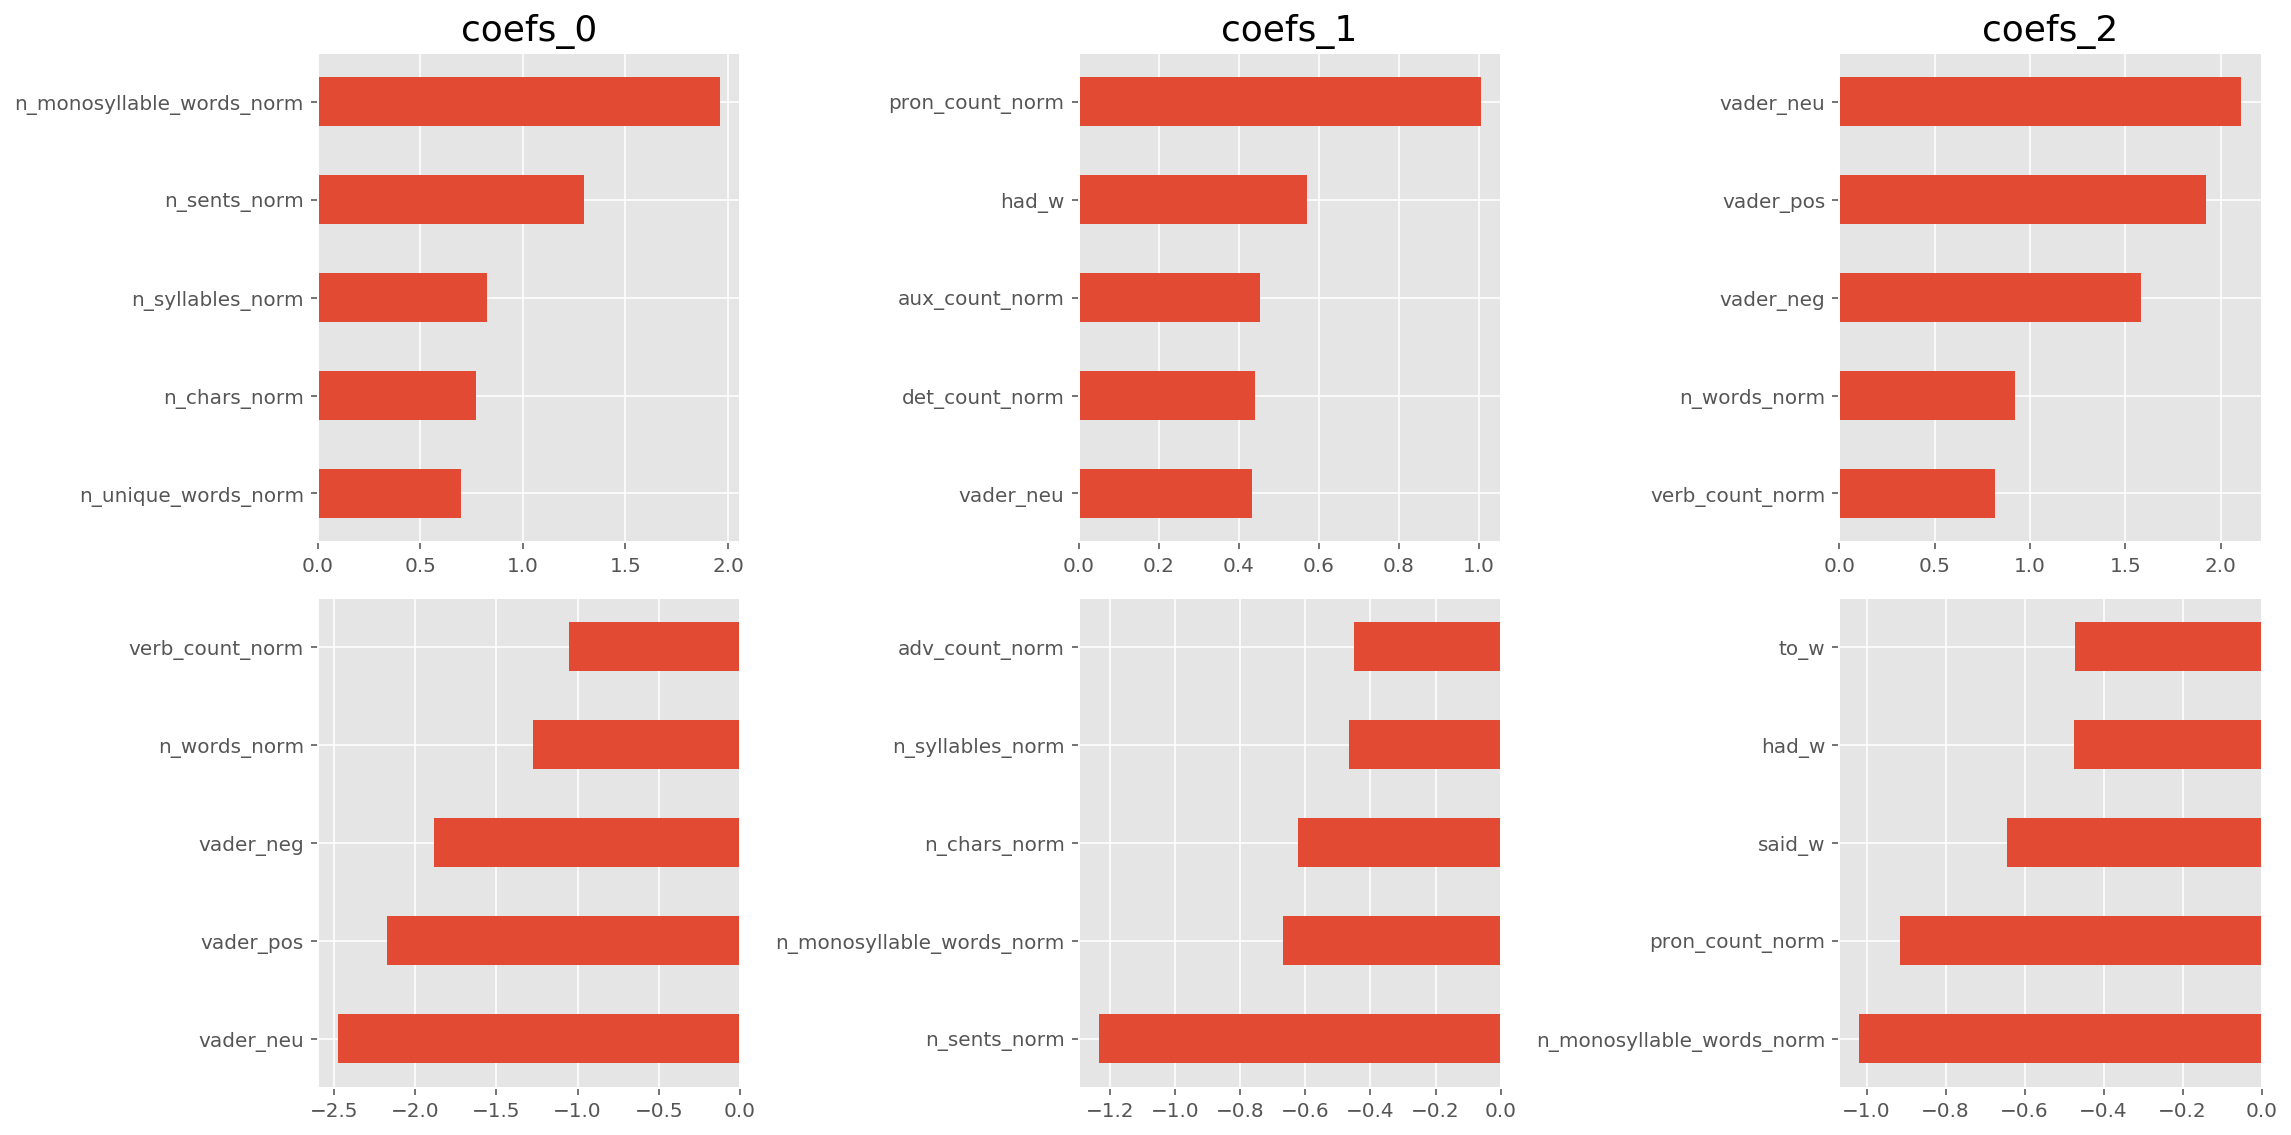

In [89]:
predictor_cols = feature_select(basic_counts=True, pos_counts=True, words=True, adj=True, adv=True, vader=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(lreg_gs_06.best_estimator_.coef_, columns=predictor_cols,
                       index=['coefs_0', 'coefs_1', 'coefs_2']).T

fig, ax = plt.subplots(nrows=2, ncols=len(df_coef.columns), figsize=(16, 8))
for i, col in enumerate(df_coef.columns):
    df_coef[col].sort_values(ascending=True).tail(5).plot(kind='barh', ax=ax[0,i])
    ax[0,i].set_title(str(col), fontsize=18)
    df_coef[col].sort_values(ascending=True).head(5).plot(kind='barh', ax=ax[1,i])
plt.tight_layout()
plt.show()

## Comments on Parameter Coefficients
* vader sentiment scores don't seem to contribute much and risk being linked more to the text itself rather than the translator style which we're interested in
* n_monosyllable_words_norm, n_sents_norm and n_syllables_norm parameters consistently have the highest positive coefficients for predicting translator 0 (Birnbaum). Aux_count verb_count are the highest negative coefficients
* pron_count_norm, n_words_norm and the word 'had' have the highest positive coefficients for predicting translator 1 (Rubin). n_sents and n_monosyllable_words have the highest negative coefficients.
* Aux_count, verb_count, adverb_count and prop_noun_counts have the highest positive coefficients for predicting translator 2 (Gabriel). n_monosyllable_words has the highest negative coefficient

## Run a best logistic regression

In [90]:
lreg_gs_06.best_params_

{'C': 100, 'penalty': 'l2'}

In [91]:
predictor_cols = feature_select(basic_counts=True, pos_counts=True, vader=False, words=True, adj=True, adv=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]

X = df[predictor_cols]
y = df['trans_code']

indices = list(df.index)

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, indices, test_size=0.2, stratify=y, random_state=1)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

lreg_final = LogisticRegression(C=1, penalty='l1', solver='liblinear', multi_class='ovr', max_iter=1000)

lreg_final.fit(X_train, y_train)
predictions = lreg_final.predict(X_test)
lreg_final.score(X_test, y_test)

0.7084639498432602

In [92]:
# code could be useful for refactoring some of the code abobe - extracting from tuples/dicts etc to df
# df_pred = pd.DataFrame([(x.r_ui, x.est) for x in predictions_full],
#                        columns=['Rating', 'Predicted'])

In [93]:
# set the output path and name
out_path = '../../../Documents/murakami/pkl_models/'
out_name = 'lreg_final_ns'
out_full_path = out_path + out_name + '.pkl'

# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(lreg_final, fp)

## Review most confidently predicted texts per translator

In [94]:
# Get the predicted probabilities and explicitly name the columns:
Y_pp = pd.DataFrame(lreg_final.predict_proba(X_test), 
             columns=['trans_0_pp', 'trans_1_pp', 'trans_2_pp'])
# add the original indices from before the train test shuffle
Y_pp['original_index'] = idx_test
Y_pp.head()

,trans_0_pp,trans_1_pp,trans_2_pp,original_index
0,0.318343,0.361005,0.320652,1524
1,0.078606,0.166988,0.754406,2738
2,0.167167,0.671310,0.161523,3546
3,0.196490,0.241802,0.561708,2698
4,0.126347,0.797759,0.075894,3386


In [95]:
Y_pp_merged = Y_pp.merge(df, how='left', left_on='original_index', right_index=True)

In [96]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title', 'book_chunk_no', 'number']] \
                                  .sort_values('trans_0_pp', ascending=False).head(5)

,trans_0_pp,trans_1_pp,trans_2_pp,chunks,translator,book_title,book_chunk_no,number
385,0.940167,0.038205,0.021627,"No matter how out of focus the picture, I had...",Alfred Birnbaum,Dance Dance Dance,163,13
43,0.900264,0.043974,0.055762,Then Hatsumi once again said she knew a girl s...,Alfred Birnbaum,Norwegian Wood,118,8
557,0.897933,0.021655,0.080412,"He looked it over, folded it in quarters, and ...",Alfred Birnbaum,The Elephant Vanishes,379,10
834,0.896912,0.058032,0.045056,I’d probably have to bring it into the garage ...,Alfred Birnbaum,The Elephant Vanishes,251,7
710,0.893642,0.084295,0.022063,“I don’t disappear so easily. I’m not going a...,Alfred Birnbaum,Dance Dance Dance,625,43


In [97]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title', 'book_chunk_no', 'number']] \
                                  .sort_values('trans_1_pp', ascending=False).head(5)

,trans_0_pp,trans_1_pp,trans_2_pp,chunks,translator,book_title,book_chunk_no,number
489,0.000253,0.994691,0.005057,"I looked around, and I examined myself, and I...",Jay Rubin,The Wind Up Bird Chronicle,637,14
603,0.004227,0.985726,0.010047,His first victim was the man who had been the...,Jay Rubin,The Wind Up Bird Chronicle,1148,32
163,0.012455,0.983190,0.004355,"I listened, making suitable responses. I heard...",Jay Rubin,The Wind Up Bird Chronicle,88,4
660,0.006454,0.983070,0.010476,"When I had finished speaking, a deep silence ...",Jay Rubin,The Wind Up Bird Chronicle,1205,34
110,0.008146,0.978196,0.013658,I should eat the top box straight away because...,Jay Rubin,Norwegian Wood,592,2


In [98]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title', 'book_chunk_no', 'number']] \
                                  .sort_values('trans_2_pp', ascending=False).head(5)

,trans_0_pp,trans_1_pp,trans_2_pp,chunks,translator,book_title,book_chunk_no,number
928,0.021528,0.033270,0.945202,He tried to open his eyes but couldn’t. He jus...,Philip Gabriel,Kafka On The Shore,480,24
702,0.016376,0.044790,0.938834,He had no idea what people coming to buy a Le...,Philip Gabriel,Colorless Tsukuru Tazaki,197,10
587,0.020067,0.049904,0.930029,"So I get lost, and can’t buy tickets, either.""...",Philip Gabriel,Kafka On The Shore,419,22
565,0.044857,0.038810,0.916332,"He got a simple train schedule, sat down on a...",Philip Gabriel,Colorless Tsukuru Tazaki,446,19
306,0.050239,0.053459,0.896303,At eight-thirty they went out to the rental c...,Philip Gabriel,Kafka On The Shore,716,38


## Most confident for translator 0: 
* better now without 'A wild sheep chase' with the strange dialogue!

In [99]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_0_pp', ascending=False).iloc[0,3]

' No matter how out of focus the picture, I had to unravel each strand patiently. Unravel, then bind all together. I had to recover my world. But where to begin? Not a clue. I was flat against a high wall. Everything was mirror-slick. No place for the hand, no place to reach out and grab. I was at wit’s end. I paid my bill and left. Big flakes of snow tumbled down from the sky. It wasn’t really coming down yet, but the sound of the town was different because of the snow. I walked briskly around the block to sober up. Where to begin? Where to go? I didn’t know. I was rusting, badly. Alone like this, I would gradually render myself useless. Great, just great. Where to begin? My receptionist friend? She seemed nice. I did like her. I did feel a bond between us. I could sleep with her if I tried. But then what? Where would I go from there? Nowhere, probably. Just another thing to lose. I don’t know what I want . And, if that’s the case, as my ex-wife said, I’d only hurt people.'

In [100]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_0_pp', ascending=False).iloc[1,3]

'Then Hatsumi once again said she knew a girl she wanted to introduce me to. An eternal go\xadaround between Hatsumi and me. An under\xadclasswoman from her club whom I was always avoiding. lOS "But she really is such a nice girl. Pretty, too. I’ll bring her along next time so you can meet her. I’m sure you’ll hit it off." "No, really," I demurred. "I’m too poor to go out with any of the girls from your school. I do�’t have money and we wouldn’t have anything to talk about." "Don’t you believe it. She’s really straightfor\xadward and nice. Not stuck up at all." "At least you ought to meet her once," said Nagasawa. "You don’t have to jump on her or anything." "Of course not. In fact, that’d wouldn’t do at all. She’s still a virgin," said Hatsumi. "Just like you once were." "Yes, just like I once was," said Hatsumi with a smile. "But honestly, Watanabe, what does it mat\xadter if you’ve got money or not? Sure, th�re are a few die-hard snobs in my class, but the rest of them are regular e

In [101]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_0_pp', ascending=False).iloc[2,3]

'He looked it over, folded it in quarters, and slipped it into his business-card case. “It’s a good encyclopedia, you know. I’m not just saying that because I sell them. Really, it’s well done. Lots of color photos. Very handy. Sometimes I’ll thumb through the thing myself, and I never get bored.” “Someday, when my ship comes in, maybe I’ll buy one.” “That’d be nice,” he said, an election-poster smile returning to his face. “But by then, I’ll probably have done my time with encyclopedias. I mean, there’s only so many Chinese families to visit. Maybe I’ll have moved on to insurance for Chinese. Or funeral plots. What’s it really matter?” I wanted to say something. I would never see this guy again in my life. I wanted to say something to him about the Chinese, but what? Nothing came. So we parted with your usual good-byes. Even now, I still can’t think of anything to say. 5.'

## Most confident for translator 1

In [102]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_1_pp', ascending=False).iloc[0,3]

' I looked around, and I examined myself, and I realized that I had become a new person, quite different from what I had been until then. This was my third self. My first self had been the one that lived in the endless anguish of pain. My second self had been the one that lived in a state of pain-free numbness. The first one had been me in my original state, unable to shift the heavy yoke of pain from my neck. And when I did attempt to shift it – which is to say, when I tried to kill myself and failed – I became my second self: an interim me. True, the physical pain that had tortured me until then had disappeared, but all other sensations had retreated with it into the haze. My will to live, my physical vitality, my mental powers of concentration: all these had disappeared along with the pain. After I passed through that strange period of transition, what emerged was a brand-new me. Whether this was the me that should have been there all along I could not yet tell.'

In [103]:
# import re
# test_txt_2 = re.sub("\'","’",test_txt)
# test_txt_2


In [104]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_1_pp', ascending=False).iloc[1,3]

' His first victim was the man who had been the central figure on the committee: the colonel. He had confronted Boris directly to represent the interests of the Japanese prisoners of war on several issues, as a result of which he was eliminated. By that time, the colonel and a few of his cohorts were the only members of the committee who did not belong to Boris. They suffocated him one night, holding him down while one of them pressed a wet towel to his face. Boris ordered the job to be done, of course, though he never dirtied his own hands when it came to killing Japanese. He issued orders to the committee and had other Japanese do it. The colonel’s death was written off simply as the result of illness. We all knew who had killed him, but no one could talk about it. We knew that Boris had spies among us, and we had to be careful what we said in front of anyone. After the colonel was murdered, the committee voted for Boris’s handpicked candidate to fill his chair .'

In [105]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_1_pp', ascending=False).iloc[2,3]

'I listened, making suitable responses. I heard no more than half of what she was saying. Not that I disliked listening to her talk about these things. Contents of the conversation aside, I loved watching her at the dinner table as she talked with enthusiasm about her work. This, I told myself, was “home”. We were doing a proper job of carrying out the responsibilities that we had been assigned to perform at home. She was talking about her work, and I, after having prepared dinner, was listening to her talk. This was very different from the image of home that I had imagined before marriage. But this was the home I had chosen . I had had a home, of course, when I was a child. But it was not one I had chosen for myself. I had been born into it, presented with it as an established fact. Now, however, I lived in a world that I had chosen through an act of will. It was my home.'

## Most confident for translator 2

In [106]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_2_pp', ascending=False).iloc[0,3]

'He tried to open his eyes but couldn’t. He just lay there, helpless, facedown on the tatami, drooling, tears streaming down his face. He must have endured this for some thirty seconds or so. Finally he was able to breathe again, and he staggered as he sat up. The tatami wavered before him like the sea in a storm. "I’m sure it was painful." Hoshino shook his head a few times, as if checking to see that he was still alive. "Pain doesn’t begin to describe it. Imagine getting skinned alive, skewered, ground down, then run over by an angry herd of bulls. What the hell did you do to me?" "I put your bones back in the right position. You should be fine for the time being.Your back won’t ache. And I guarantee you’ll take good dumps." As predicted, when the pain receded, like the tide going out, his back did feel better. The usual heavy, sluggish feeling had vanished. The area around his temples felt much better, and he could breathe more easily. And sure enough, he felt like going to the john

In [107]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_2_pp', ascending=False).iloc[1,3]

' He had no idea what people coming to buy a Lexus normally wore, but they might not have taken him seriously if he’d been decked out in a polo shirt, jeans, and sneakers. Just before he left the house, he had suddenly changed his mind and put on a suit and tie. He was kept waiting for fifteen minutes, during which time he learned the entire lineup of Lexus models. He discovered that Lexus didn’t give their different models names, like Corolla or Crown, but instead used numbers to distinguish models. Just like Mercedes-Benz and BMW. And Brahms symphonies. A tall man finally appeared. He crossed the showroom in Tsukuru’s direction. He was broad-shouldered, and carried himself in a decisive manner, letting those around him know he was not about to waste any time getting from point A to point B. It was definitely Ao. Even seen from a distance, he looked nearly the same as he had in high school. He’d grown a little bigger, that was all, like a house with an addition when the family grows. 

In [108]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_2_pp', ascending=False).iloc[2,3]

'So I get lost, and can’t buy tickets, either." "Incredible you were able to get this far." "Many people were kind enough to help me. You’re one of them, Mr. Hoshino. I don’t know how to thank you." "That must be tough, though, not being able to read. My grandad was pretty senile, but he could still read well enough." "I’m especially dumb." "Is everybody in your family like that?" "No, they aren’t. My older brother is a depart mint head at a place called Itoh-chew, and my younger brother works at an office called Em-i-tee-i." "Wow," Hoshino said. "Pretty elite bunch. So you’re the only one who’s a bit off, huh?" "Yes, Nakata’s the only one who had an accident and isn’t bright. That’s why I’m always being told not to go out too much and cause any trouble for my brothers, nieces, and nephews."  "Yeah, I guess most people would find it kind of awkward to have someone like you show up." "I don’t understand difficult things, but I know that as long as I stay in Nakano Ward I don’t get lost.

## Look at key predictor values for most confident results

In [111]:
top_b = Y_pp_merged.sort_values('trans_0_pp', ascending=False).head(1)
top_b

,trans_0_pp,trans_1_pp,trans_2_pp,original_index,book_chunk_no,number,title,text,fstop_indices,split_indices,chunks,translator,book_title,parsed,n_sents,n_words,n_chars,n_syllables,n_unique_words,n_long_words,n_monosyllable_words,n_polysyllable_words,trans_code,chunk_length,n_sents_norm,n_words_norm,n_chars_norm,n_syllables_norm,n_unique_words_norm,n_long_words_norm,n_monosyllable_words_norm,n_polysyllable_words_norm,vader_compound,vader_neg,vader_neu,vader_pos,pron_count,verb_count,det_count,adj_count,num_count,punct_count,noun_count,adp_count,cconj_count,sconj_count,adv_count,aux_count,part_count,propn_count,...,where_adv,too_adv,now_adv,all_adv,then_adv,just_adv,really_adv,there_adv,only_adv,even_adv,as_adv,always_adv,when_adv,again_adv,here_adv,maybe_adv,still_adv,back_adv,why_adv,very_adv,never_adv,how_adv,whole_adj,small_adj,long_adj,able_adj,more_adj,sure_adj,big_adj,last_adj,bad_adj,old_adj,same_adj,good_adj,new_adj,only_adj,different_adj,other_adj,next_adj,few_adj,much_adj,hard_adj,real_adj,young_adj,own_adj,first_adj,deep_adj,strange_adj,little_adj,right_adj
385,0.940167,0.038205,0.021627,4470,163,13,13,\n KNOTS . \n It was nine P.M . I was eating...,"[8, 26, 29, 101, 166, 223, 272, 324, 375, 420,...","[979, 1957, 2977, 3998]","No matter how out of focus the picture, I had...",Alfred Birnbaum,Dance Dance Dance,"( , No, matter, how, out, of, focus, the, pict...",32,198,752,242,120,20,168,12,0,987,32.421479,200.607903,761.904762,245.187437,121.580547,20.263425,170.212766,12.158055,0.7699,0.123,0.734,0.143,26.0,34.0,21.0,9.0,0.0,43.0,29.0,15.0,6.0,6.0,26.0,12.0,14.0,0.0,...,5,0,0,1,2,2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [112]:
top_r = Y_pp_merged.sort_values('trans_1_pp', ascending=False).head(1)
top_r

,trans_0_pp,trans_1_pp,trans_2_pp,original_index,book_chunk_no,number,title,text,fstop_indices,split_indices,chunks,translator,book_title,parsed,n_sents,n_words,n_chars,n_syllables,n_unique_words,n_long_words,n_monosyllable_words,n_polysyllable_words,trans_code,chunk_length,n_sents_norm,n_words_norm,n_chars_norm,n_syllables_norm,n_unique_words_norm,n_long_words_norm,n_monosyllable_words_norm,n_polysyllable_words_norm,vader_compound,vader_neg,vader_neu,vader_pos,pron_count,verb_count,det_count,adj_count,num_count,punct_count,noun_count,adp_count,cconj_count,sconj_count,adv_count,aux_count,part_count,propn_count,...,where_adv,too_adv,now_adv,all_adv,then_adv,just_adv,really_adv,there_adv,only_adv,even_adv,as_adv,always_adv,when_adv,again_adv,here_adv,maybe_adv,still_adv,back_adv,why_adv,very_adv,never_adv,how_adv,whole_adj,small_adj,long_adj,able_adj,more_adj,sure_adj,big_adj,last_adj,bad_adj,old_adj,same_adj,good_adj,new_adj,only_adj,different_adj,other_adj,next_adj,few_adj,much_adj,hard_adj,real_adj,young_adj,own_adj,first_adj,deep_adj,strange_adj,little_adj,right_adj
489,0.000253,0.994691,0.005057,3052,637,14,Creta Kano’s New Departure \n •,CRETA KANO WENT on with her story. \n “For so...,"[34, 119, 183, 239, 388, 467, 564, 624, 699, 8...","[997, 1987, 2848, 3997, 4905, 5973, 6935, 7911...","I looked around, and I examined myself, and I...",Jay Rubin,The Wind Up Bird Chronicle,"( , I, looked, around, ,, and, I, examined, my...",11,187,765,239,95,23,152,15,1,978,11.247444,191.206544,782.208589,244.376278,97.137014,23.517382,155.419223,15.337423,-0.9565,0.136,0.832,0.031,21.0,24.0,33.0,20.0,0.0,26.0,28.0,19.0,5.0,2.0,9.0,20.0,6.0,0.0,...,0,0,0,1,2,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,1,0,0,0,0,0,0,0,2,0,1,0,0


In [113]:
top_g = Y_pp_merged.sort_values('trans_2_pp', ascending=False).head(1)
top_g

,trans_0_pp,trans_1_pp,trans_2_pp,original_index,book_chunk_no,number,title,text,fstop_indices,split_indices,chunks,translator,book_title,parsed,n_sents,n_words,n_chars,n_syllables,n_unique_words,n_long_words,n_monosyllable_words,n_polysyllable_words,trans_code,chunk_length,n_sents_norm,n_words_norm,n_chars_norm,n_syllables_norm,n_unique_words_norm,n_long_words_norm,n_monosyllable_words_norm,n_polysyllable_words_norm,vader_compound,vader_neg,vader_neu,vader_pos,pron_count,verb_count,det_count,adj_count,num_count,punct_count,noun_count,adp_count,cconj_count,sconj_count,adv_count,aux_count,part_count,propn_count,...,where_adv,too_adv,now_adv,all_adv,then_adv,just_adv,really_adv,there_adv,only_adv,even_adv,as_adv,always_adv,when_adv,again_adv,here_adv,maybe_adv,still_adv,back_adv,why_adv,very_adv,never_adv,how_adv,whole_adj,small_adj,long_adj,able_adj,more_adj,sure_adj,big_adj,last_adj,bad_adj,old_adj,same_adj,good_adj,new_adj,only_adj,different_adj,other_adj,next_adj,few_adj,much_adj,hard_adj,real_adj,young_adj,own_adj,first_adj,deep_adj,strange_adj,little_adj,right_adj
928,0.021528,0.03327,0.945202,951,480,24,Chapter 24,It was already eight p. m. when their bus from...,"[22, 25, 89, 103, 124, 133, 162, 206, 318, 386...","[999, 1944, 2937, 3963, 4976, 5943, 6948, 7972...",He tried to open his eyes but couldn’t. He jus...,Philip Gabriel,Kafka On The Shore,"(He, tried, to, open, his, eyes, but, could, n...",20,191,777,233,131,27,155,6,2,1000,20.0,191.0,777.0,233.0,131.0,27.0,155.0,6.0,-0.1692,0.171,0.649,0.18,20.0,39.0,23.0,18.0,1.0,39.0,27.0,16.0,6.0,8.0,14.0,10.0,7.0,2.0,...,0,0,0,0,1,1,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [119]:
top_predictions = Y_pp_merged[Y_pp_merged.index.isin([385,489,928])]

In [10]:
df.columns

Index(['book_chunk_no', 'number', 'title', 'text', 'fstop_indices',
       'split_indices', 'chunks', 'translator', 'book_title', 'parsed',
       ...
       'much_adj', 'hard_adj', 'real_adj', 'young_adj', 'own_adj', 'first_adj',
       'deep_adj', 'strange_adj', 'little_adj', 'right_adj'],
      dtype='object', length=141)

In [29]:
df.n_monosyllable_words_norm.mean()

154.36772037891043

In [30]:
df[(df['book_title'] == 'Dance Dance Dance') & (df['book_chunk_no'] == 163)]['n_monosyllable_words_norm']

4470    170.212766
Name: n_monosyllable_words_norm, dtype: float64

In [32]:
df.n_sents_norm.mean()

17.919489209288123

In [33]:
df[(df['book_title'] == 'Dance Dance Dance') & (df['book_chunk_no'] == 163)]['n_sents_norm']

4470    32.421479
Name: n_sents_norm, dtype: float64

In [34]:
df.verb_count_norm.mean()

32.29048277322802

In [35]:
df[(df['book_title'] == 'Dance Dance Dance') & (df['book_chunk_no'] == 163)]['verb_count_norm']

4470    34.447822
Name: verb_count_norm, dtype: float64

In [31]:
# df[(df['book_title'] == 'Dance Dance Dance') & (df['book_chunk_no'] == 163)]['n_monosyllable_words_norm'] \
#                 .plot()

# plt.show()

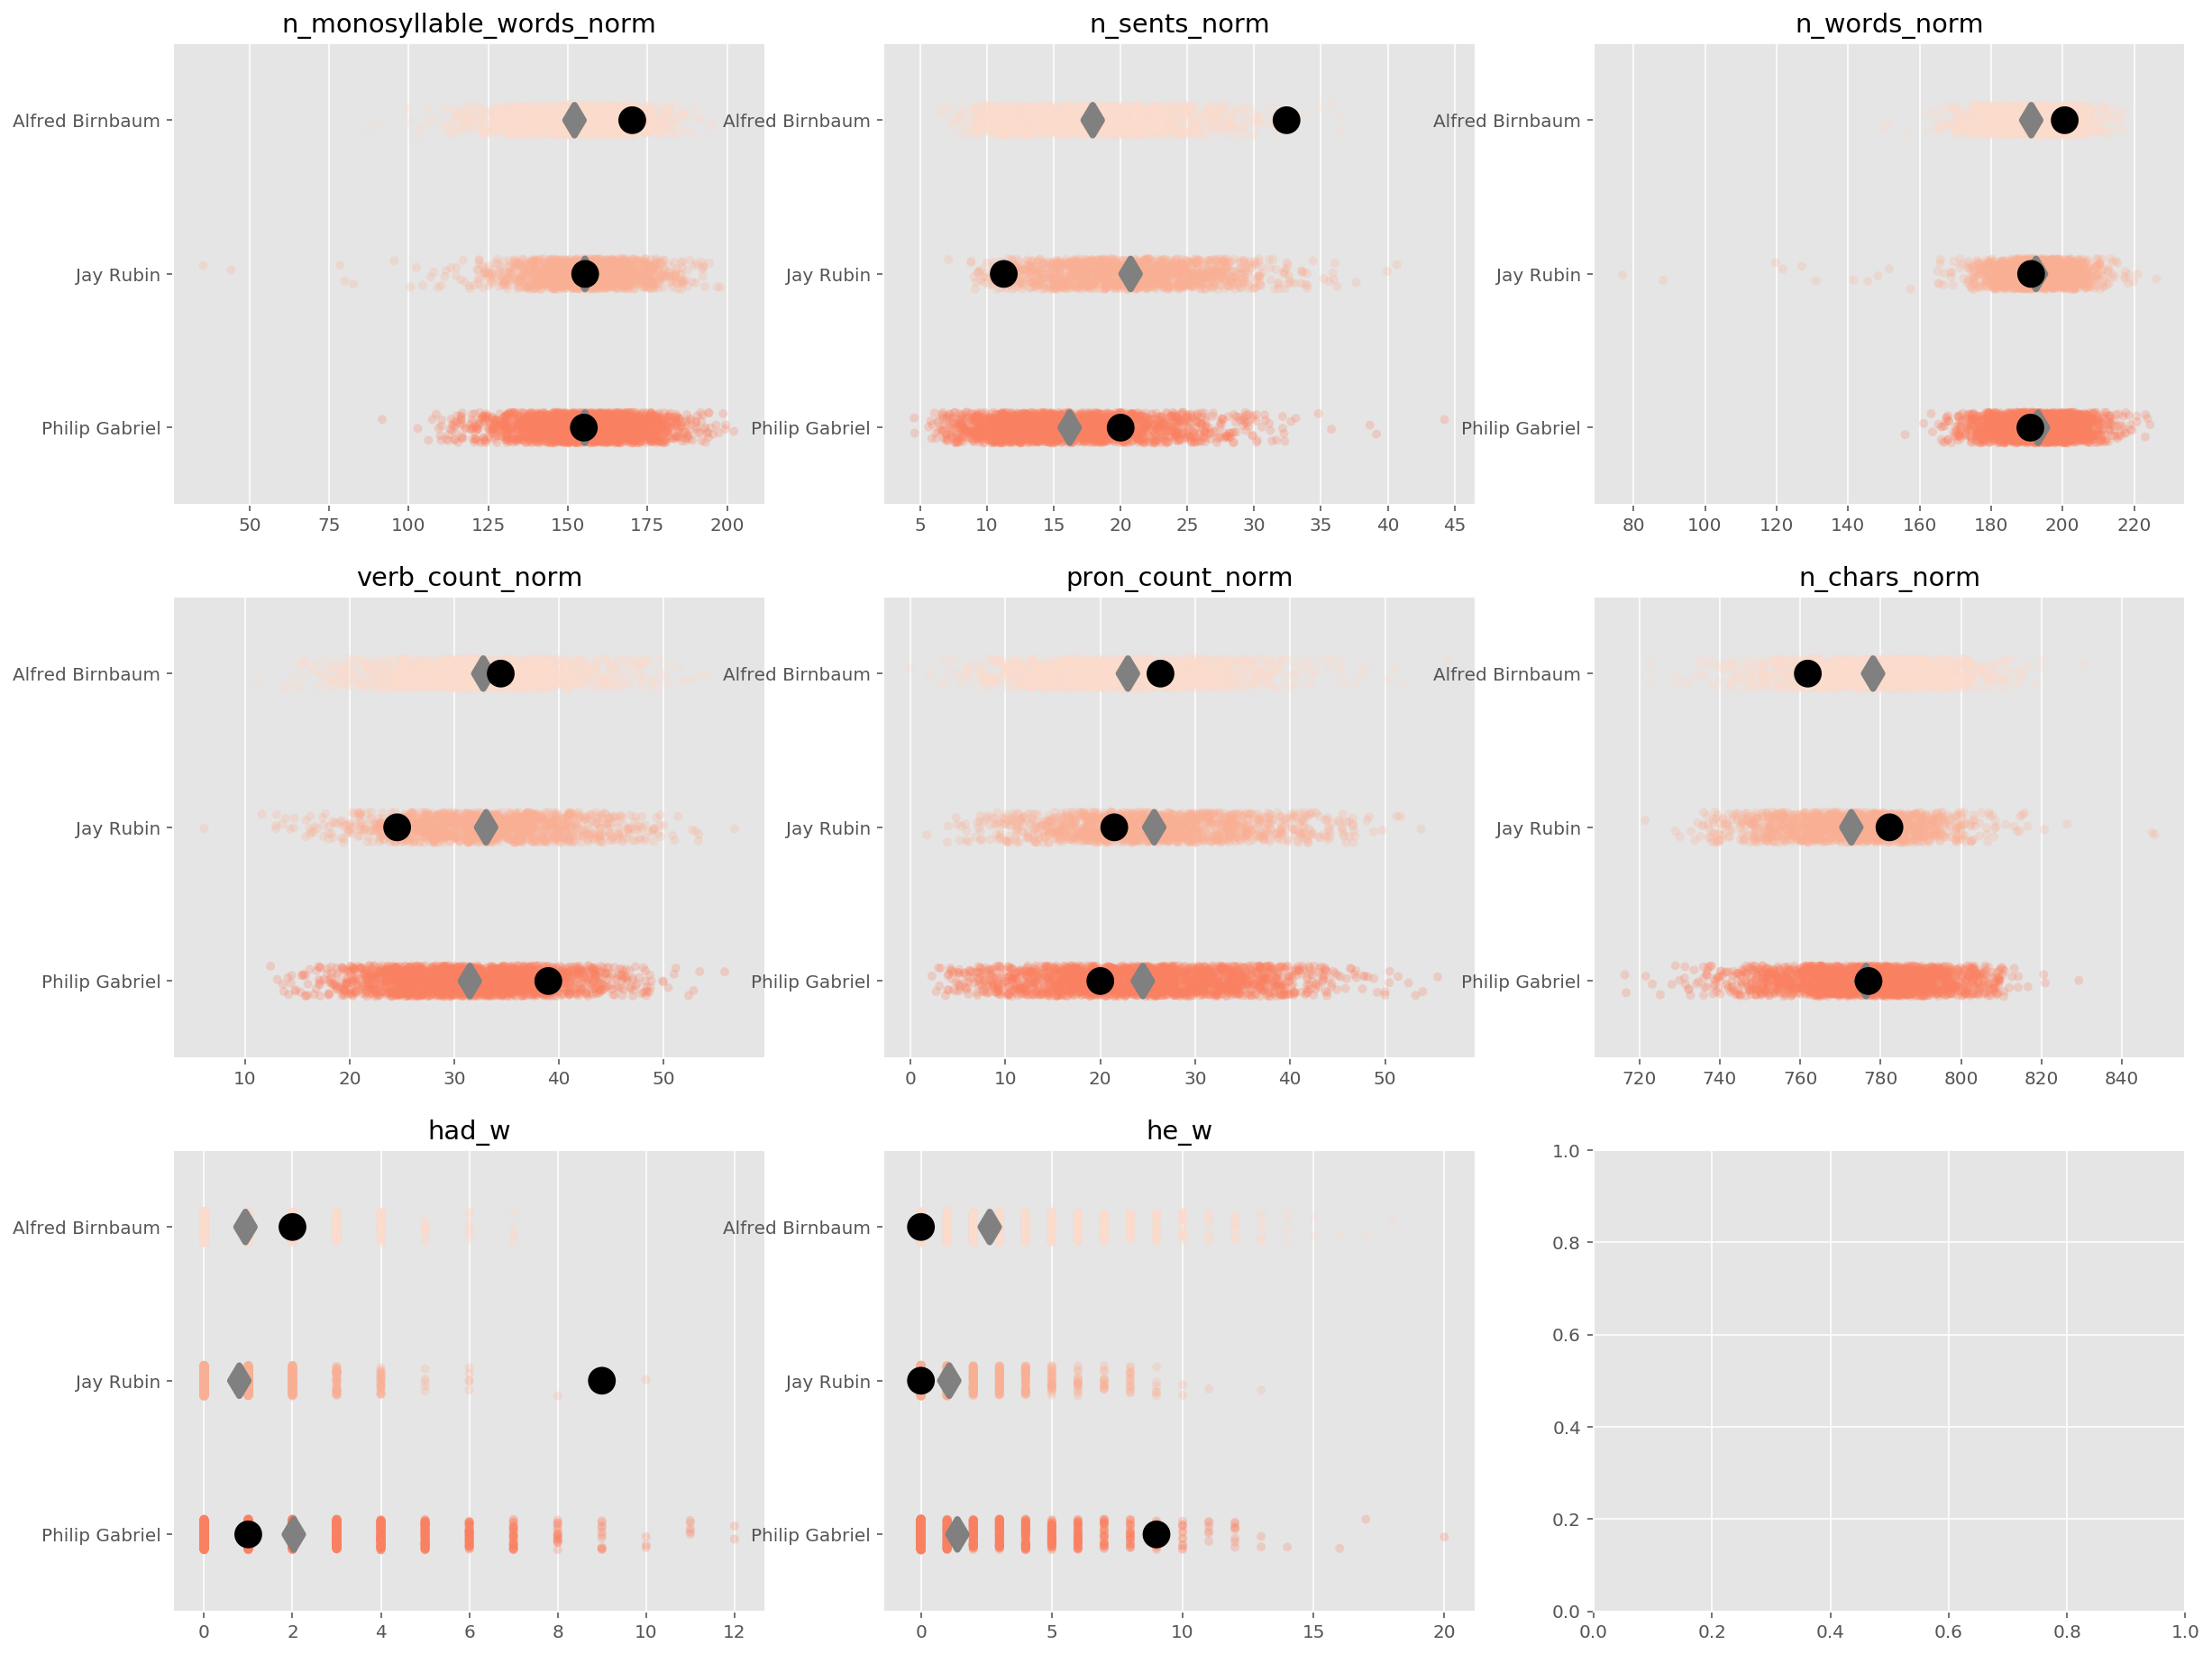

In [174]:
sns.set_palette("Reds")
preds2plot = ['n_monosyllable_words_norm',
              'n_sents_norm',
              'n_words_norm',
              'verb_count_norm',
              'pron_count_norm',
              'n_chars_norm',
              'had_w',
              'he_w']
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20, 16), sharex=False)

for i in range(len(preds2plot)):
    sns.stripplot(x=preds2plot[i], y='translator',
                  data=df, dodge=True, alpha=.25, zorder=1, ax=ax[int(i/3),i%3])
    # Show the conditional means
    sns.pointplot(x=preds2plot[i], y='translator',
                  data=df, dodge=.532, join=False, color='grey',
                  markers="d", scale=1.75, ci=None, ax=ax[int(i/3),i%3])

    # Show the individual values for most confident predictions
    sns.pointplot(x=preds2plot[i], y="translator",
                  data=top_predictions, dodge=.532, join=False, color='black',
                  markers="o", scale=1.75, ci=None, ax=ax[int(i/3),i%3])
    ax[int(i/3),i%3].set_title(preds2plot[i])
    ax[int(i/3),i%3].set_xlabel('')
    ax[int(i/3),i%3].set_ylabel('')

# plt.subplots_adjust(hspace=0.6)
plt.show()

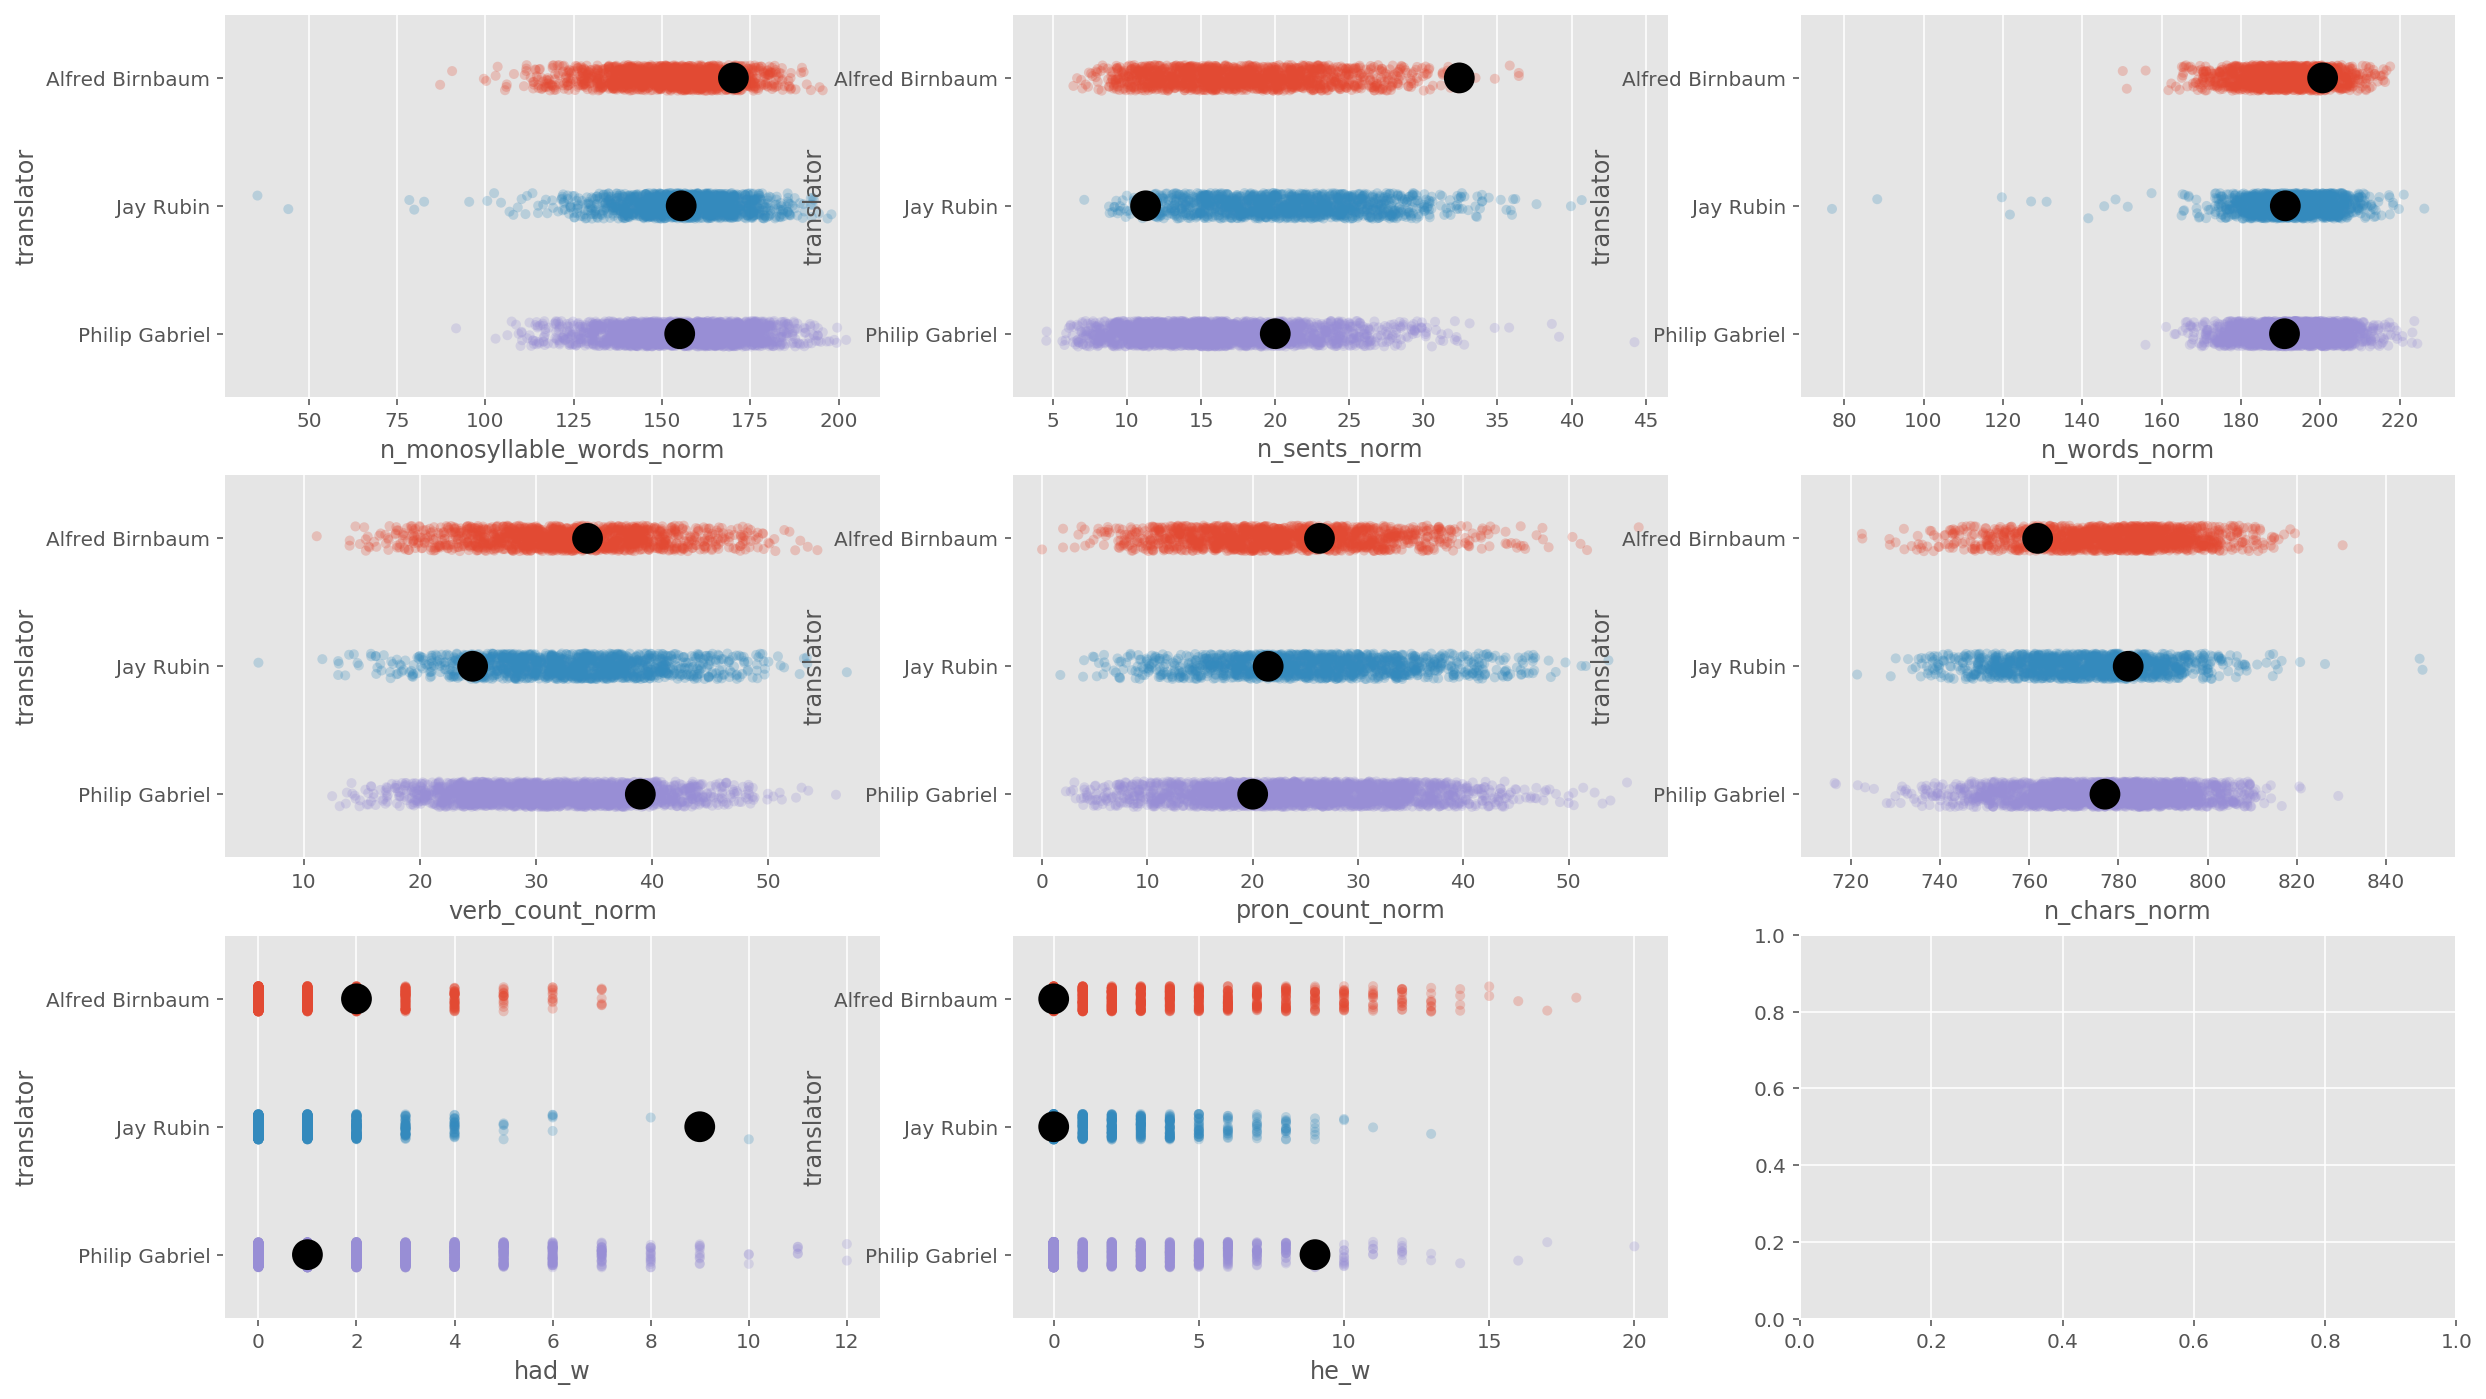

In [142]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20, 12), sharex=False)
# sns.despine(bottom=True, left=True)
# Show each observation with a scatterplot
sns.stripplot(x='n_monosyllable_words_norm', y='translator',
              data=df, dodge=True, alpha=.25, zorder=1, ax=ax[0,0])
# Show the individual values for most confident predictions
sns.pointplot(x="n_monosyllable_words_norm", y="translator",
              data=top_predictions, dodge=.532, join=False, color='black',
              markers="o", scale=1.75, ci=None, ax=ax[0,0])

# Show each observation with a scatterplot
sns.stripplot(x='n_sents_norm', y='translator',
              data=df, dodge=True, alpha=.25, zorder=1, ax=ax[0,1])
# Show the individual values for most confident predictions
sns.pointplot(x="n_sents_norm", y="translator",
              data=top_predictions, dodge=.532, join=False, color='black',
              markers="o", scale=1.75, ci=None, ax=ax[0,1])

# Show each observation with a scatterplot
sns.stripplot(x='n_words_norm', y='translator',
              data=df, dodge=True, alpha=.25, zorder=1, ax=ax[0,2])
# Show the individual values for most confident predictions
sns.pointplot(x="n_words_norm", y="translator",
              data=top_predictions, dodge=.532, join=False, color='black',
              markers="o", scale=1.75, ci=None, ax=ax[0,2])

# Show each observation with a scatterplot
sns.stripplot(x='verb_count_norm', y='translator',
              data=df, dodge=True, alpha=.25, zorder=1, ax=ax[1,0])
# Show the individual values for most confident predictions
sns.pointplot(x="verb_count_norm", y="translator",
              data=top_predictions, dodge=.532, join=False, color='black',
              markers="o", scale=1.75, ci=None, ax=ax[1,0])

# Show each observation with a scatterplot
sns.stripplot(x='pron_count_norm', y='translator',
              data=df, dodge=True, alpha=.25, zorder=1, ax=ax[1,1])
# Show the individual values for most confident predictions
sns.pointplot(x="pron_count_norm", y="translator",
              data=top_predictions, dodge=.532, join=False, color='black',
              markers="o", scale=1.75, ci=None, ax=ax[1,1])

# Show each observation with a scatterplot
sns.stripplot(x='n_chars_norm', y='translator',
              data=df, dodge=True, alpha=.25, zorder=1, ax=ax[1,2])
# Show the individual values for most confident predictions
sns.pointplot(x="n_chars_norm", y="translator",
              data=top_predictions, dodge=.532, join=False, color='black',
              markers="o", scale=1.75, ci=None, ax=ax[1,2])



# Show each observation with a scatterplot
sns.stripplot(x='had_w', y='translator',
              data=df, dodge=True, alpha=.25, zorder=1, ax=ax[2,0])
# Show the individual values for most confident predictions
sns.pointplot(x="had_w", y="translator",
              data=top_predictions, dodge=.532, join=False, color='black',
              markers="o", scale=1.75, ci=None, ax=ax[2,0])

# Show each observation with a scatterplot
sns.stripplot(x='he_w', y='translator',
              data=df, dodge=True, alpha=.25, zorder=1, ax=ax[2,1])
# Show the individual values for most confident predictions
sns.pointplot(x="he_w", y="translator",
              data=top_predictions, dodge=.532, join=False, color='black',
              markers="o", scale=1.75, ci=None, ax=ax[2,1])

plt.show()

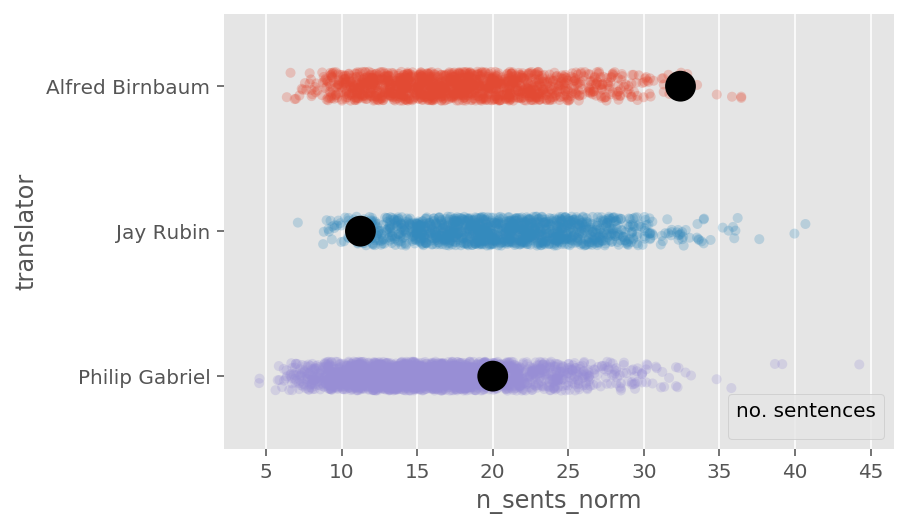

In [131]:
f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
sns.stripplot(x='n_sents_norm', y='translator',
              data=df, dodge=True, alpha=.25, zorder=1)
# Show the individual values for most confident predictions
sns.pointplot(x="n_sents_norm", y="translator",
              data=top_predictions, dodge=.532, join=False, color='black',
              markers="o", scale=1.75, ci=None)

# Improve the legend 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[3:], labels[3:], title="no. sentences",
          handletextpad=0, columnspacing=1,
          loc="lower right", ncol=3, frameon=True)

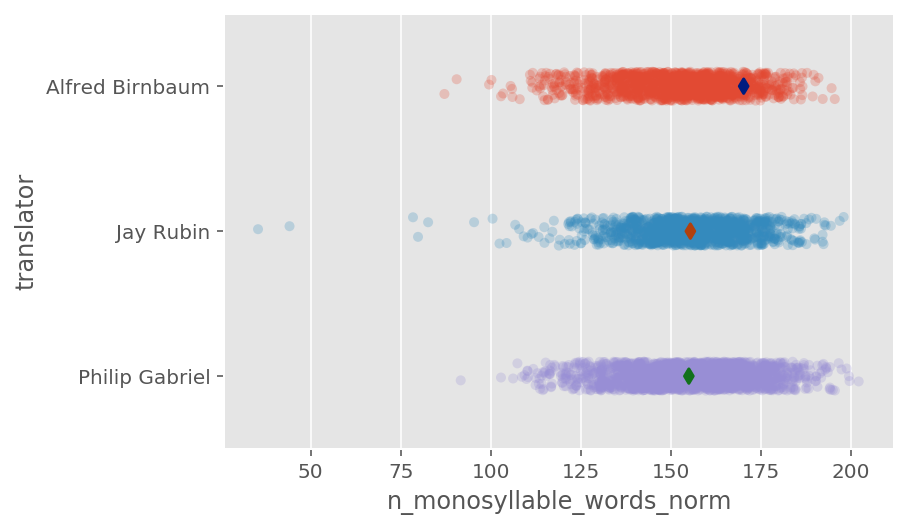

In [122]:
# Show each observation with a scatterplot
sns.stripplot(x='n_monosyllable_words_norm', y='translator',
              data=df, dodge=True, alpha=.25, zorder=1)
# Show the conditional means
sns.pointplot(x="n_monosyllable_words_norm", y="translator",
              data=top_predictions, dodge=.532, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

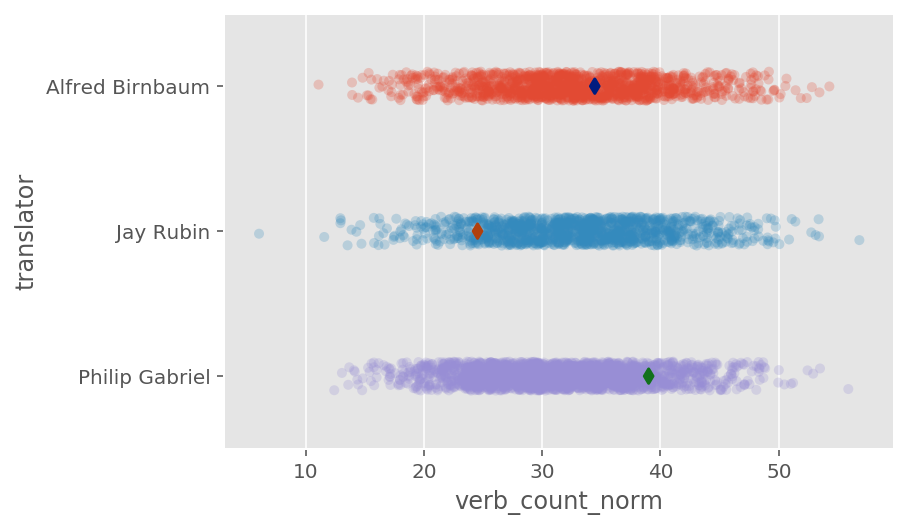

In [121]:
# Show each observation with a scatterplot
sns.stripplot(x='verb_count_norm', y='translator',
              data=df, dodge=True, alpha=.25, zorder=1)
# Show the conditional means
sns.pointplot(x="verb_count_norm", y="translator",
              data=top_predictions, dodge=.532, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

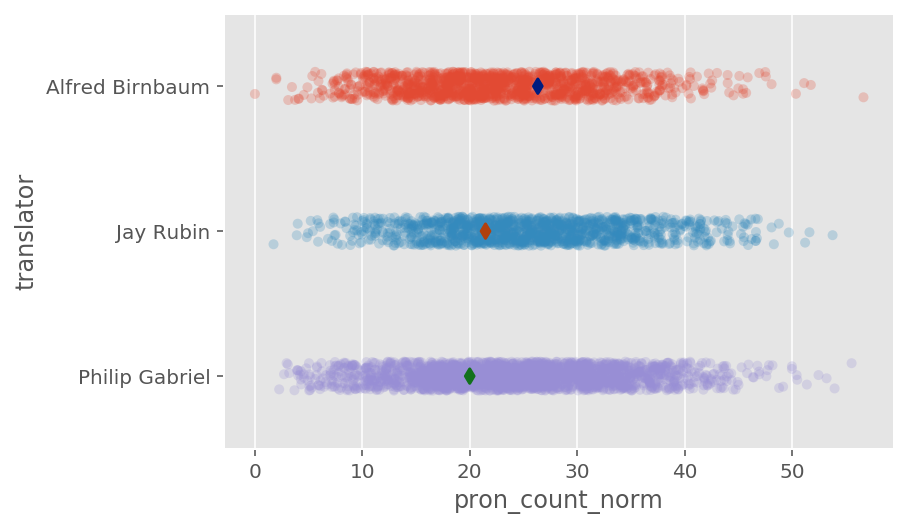

In [124]:
# Show each observation with a scatterplot
sns.stripplot(x='pron_count_norm', y='translator',
              data=df, dodge=True, alpha=.25, zorder=1)
# Show the conditional means
sns.pointplot(x="pron_count_norm", y="translator",
              data=top_predictions, dodge=.532, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

In [175]:
test_text = Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_0_pp', ascending=False).iloc[0,3]

In [181]:
en_nlp = textacy.load_spacy_lang('en_core_web_sm')
test_parsed = en_nlp(test_text)

 No matter how out of focus the picture, I had to unravel each strand patiently. Unravel, then bind all together. I had to recover my world. But where to begin? Not a clue. I was flat against a high wall. Everything was mirror-slick. No place for the hand, no place to reach out and grab. I was at wit’s end. I paid my bill and left. Big flakes of snow tumbled down from the sky. It wasn’t really coming down yet, but the sound of the town was different because of the snow. I walked briskly around the block to sober up. Where to begin? Where to go? I didn’t know. I was rusting, badly. Alone like this, I would gradually render myself useless. Great, just great. Where to begin? My receptionist friend? She seemed nice. I did like her. I did feel a bond between us. I could sleep with her if I tried. But then what? Where would I go from there? Nowhere, probably. Just another thing to lose. I don’t know what I want . And, if that’s the case, as my ex-wife said, I’d only hurt people.

In [232]:
# Colourise - colours text in shell. Returns plain if colour doesn't exist.
def colourise(colour, text):
    if colour == "black":
        return "\033[1;30m" + str(text) + "\033[1;m"
    if colour == "red":
        return "\033[1;31m" + str(text) + "\033[1;m"
    if colour == "green":
        return "\033[1;32m" + str(text) + "\033[1;m"
    if colour == "yellow":
        return "\033[1;33m" + str(text) + "\033[1;m"
    if colour == "blue":
        return "\033[1;34m" + str(text) + "\033[1;m"
    if colour == "magenta":
        return "\033[1;35m" + str(text) + "\033[1;m"
    if colour == "cyan":
        return "\033[1;36m" + str(text) + "\033[1;m"
    if colour == "gray":
        return "\033[1;37m" + str(text) + "\033[1;m"
    return str(text)

# Highlight - highlights text in shell. Returns plain if colour doesn't exist.
def highlight(colour, text):
    if colour == "black":
        return "\033[1;40m" + str(text) + "\033[1;m"
    if colour == "red":
        return "\033[1;41m" + str(text) + "\033[1;m"
    if colour == "green":
        return "\033[1;42m" + str(text) + "\033[1;m"
    if colour == "yellow":
        return "\033[1;43m" + str(text) + "\033[1;m"
    if colour == "blue":
        return "\033[1;44m" + str(text) + "\033[1;m"
    if colour == "magenta":
        return "\033[1;45m" + str(text) + "\033[1;m"
    if colour == "cyan":
        return "\033[1;46m" + str(text) + "\033[1;m"
    if colour == "gray":
        return "\033[1;47m" + str(text) + "\033[1;m"
    return str(text)

# # Example usage:
# print(colourise("black", "Black"))
# print(colourise("red", "Red"))
# print(colourise("green", "Green"))
# print(colourise("yellow", "Yellow"))
# print(colourise("blue", "Blue"))
# print(colourise("magenta", "Magenta"))
# print(colourise("cyan", "Cyan"))
# print(colourise("gray", "Gray"))
# print(highlight("black", "Highlight: black"))
# print(highlight("red", "Highlight: red"))
# print(highlight("green", "Highlight: green"))
# print(highlight("yellow", "Highlight: yellow"))
# print(highlight("blue", "Highlight: blue"))
# print(highlight("magenta", "Highlight: magenta"))
# print(highlight("cyan", "Highlight: cyan"))
# print(highlight("gray", "Highlight: gray"))

# Example usage of colourise() + highlight()
# text = "Blue on red is difficult to read because the wavelengths are \
# refracted onto different areas of the eye."

# print(highlight("red", (colourise("blue", text))))


In [229]:
# print(highlight("red", 'No matter how out of focus the picture'))

In [228]:
# test_text.split()

In [234]:
top_predictions['chunks'].iloc[0]

' No matter how out of focus the picture, I had to unravel each strand patiently. Unravel, then bind all together. I had to recover my world. But where to begin? Not a clue. I was flat against a high wall. Everything was mirror-slick. No place for the hand, no place to reach out and grab. I was at wit’s end. I paid my bill and left. Big flakes of snow tumbled down from the sky. It wasn’t really coming down yet, but the sound of the town was different because of the snow. I walked briskly around the block to sober up. Where to begin? Where to go? I didn’t know. I was rusting, badly. Alone like this, I would gradually render myself useless. Great, just great. Where to begin? My receptionist friend? She seemed nice. I did like her. I did feel a bond between us. I could sleep with her if I tried. But then what? Where would I go from there? Nowhere, probably. Just another thing to lose. I don’t know what I want . And, if that’s the case, as my ex-wife said, I’d only hurt people.'

In [259]:
for i in range(len(top_predictions)):
    text = top_predictions['chunks'].iloc[i]
    parsed = top_predictions['parsed'].iloc[i]
    verbs = [str(token) for token in parsed if token.pos_ == 'VERB' ]
    pronouns = [str(token) for token in parsed if token.pos_ == 'PRON' ]
    fin_list = []
    verb_count = 0
    pronoun_count = 0
    stop_count = 0
    for word in text.split():
        if word in verbs:
            fin_list.append(colourise("red", word))
            verb_count += 1
        elif word in pronouns:
            fin_list.append(colourise("magenta", word))
            pronoun_count += 1
        elif word == 'had':
            fin_list.append(colourise("green", word))
        elif word == 'he':
            fin_list.append(highlight("yellow", word))
        elif '.' in word:
            fin_list.append(highlight("cyan", word[-1]))
            stop_count += 1
        else:
            fin_list.append(word)

    print('\n')
    print(top_predictions['translator'].iloc[i])
#     print(highlight("red",verb_count))
    print(colourise("red",'verbs'), verb_count, '   ', 
          colourise("magenta",'pronouns'), pronoun_count, '   ', 
          highlight("cyan",'stops'), stop_count,)
    print('\n')
    print(' '.join(fin_list))
    



Alfred Birnbaum
verbs 22     pronouns 22     stops 24


No matter how out of focus the picture, I had to unravel each strand . Unravel, then bind all . I had to recover my . But where to begin? Not a . I was flat against a high . Everything was . No place for the hand, no place to reach out and . I was at wit’s . I paid my bill and . Big flakes of snow tumbled down from the . It wasn’t really coming down yet, but the sound of the town was different because of the . I walked briskly around the block to sober . Where to begin? Where to go? I didn’t . I was rusting, . Alone like this, I would gradually render myself . Great, just . Where to begin? My receptionist friend? She seemed . I did like . I did feel a bond between . I could sleep with her if I . But then what? Where would I go from there? Nowhere, . Just another thing to . I don’t know what I want . And, if that’s the case, as my ex-wife said, I’d only hurt .


Jay Rubin
verbs 20     pronouns 18     stops 10


I looked around, a

In [220]:
verbs = [str(token) for token in test_parsed if token.pos_ == 'VERB' ]
pronouns = [str(token) for token in test_parsed if token.pos_ == 'PRON' ]

In [233]:
fin_list = []
for word in test_text.split():
    if word in verbs:
        fin_list.append(highlight("red", word))
    elif word in pronouns:
        fin_list.append(highlight("green", word))
    elif word == 'had':
        fin_list.append(highlight("blue", word))
    elif word == 'he':
        fin_list.append(highlight("yellow", word))
    elif '.' in word:
        fin_list.append(highlight("cyan", word[-1]))
    else:
        fin_list.append(word)
        
print(' '.join(fin_list))


No matter how out of focus the picture, I had to unravel each strand . Unravel, then bind all . I had to recover my . But where to begin? Not a . I was flat against a high . Everything was . No place for the hand, no place to reach out and . I was at wit’s . I paid my bill and . Big flakes of snow tumbled down from the . It wasn’t really coming down yet, but the sound of the town was different because of the . I walked briskly around the block to sober . Where to begin? Where to go? I didn’t . I was rusting, . Alone like this, I would gradually render myself . Great, just . Where to begin? My receptionist friend? She seemed . I did like . I did feel a bond between . I could sleep with her if I . But then what? Where would I go from there? Nowhere, . Just another thing to . I don’t know what I want . And, if that’s the case, as my ex-wife said, I’d only hurt .


## Precision-Recall Plot

In [210]:
probabilities = lreg_final.predict_proba(X_test)

In [211]:
def plot_f1_lines(figsize=(8,6),fontsize=16):
    '''Create f1-score level lines to be added to the precison-recall plot'''

    fig, ax = plt.subplots(figsize=figsize)
    
    # add lines of constant F1 scores
    
    for const in np.linspace(0.2,0.9,8):
        x_vals = np.linspace(0.001, 0.999, 100)
        y_vals = 1./(2./const-1./x_vals)
        ax.plot(x_vals[y_vals > 0], y_vals[y_vals > 0],
                 color='lightblue', ls='--', alpha=0.9)
        ax.set_ylim([0, 1])
        ax.annotate('f1={0:0.1f}'.format(const),
                     xy=(x_vals[-10], y_vals[-2]+0.0), fontsize=fontsize)

    return fig, ax

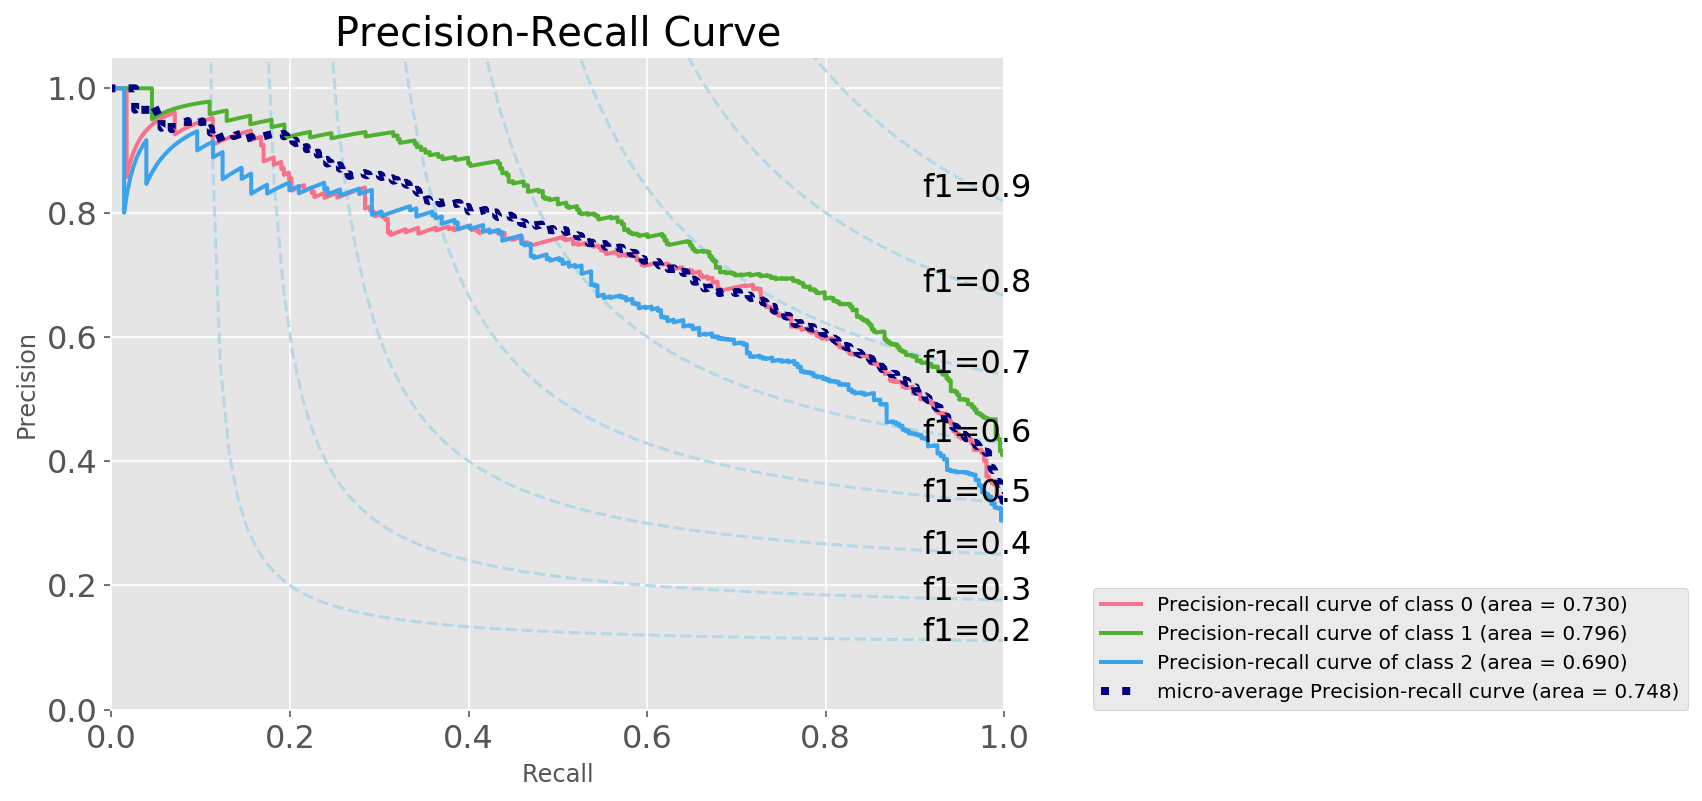

In [212]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, probabilities, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()

In [213]:
# label binarizer - not sure if needed?
y_bin = label_binarize(y_test, lreg_final.classes_)

In [214]:
print('Area under precision-recall curve:')
for i, class_ in enumerate(lreg_final.classes_):
    print('Class {}:'.format(class_), round(average_precision_score(y_bin[:,i],lreg_final.predict_proba(X_test)[:,i]),4))

Area under precision-recall curve:
Class 0: 0.7305
Class 1: 0.7964
Class 2: 0.6898


## ROC Plot

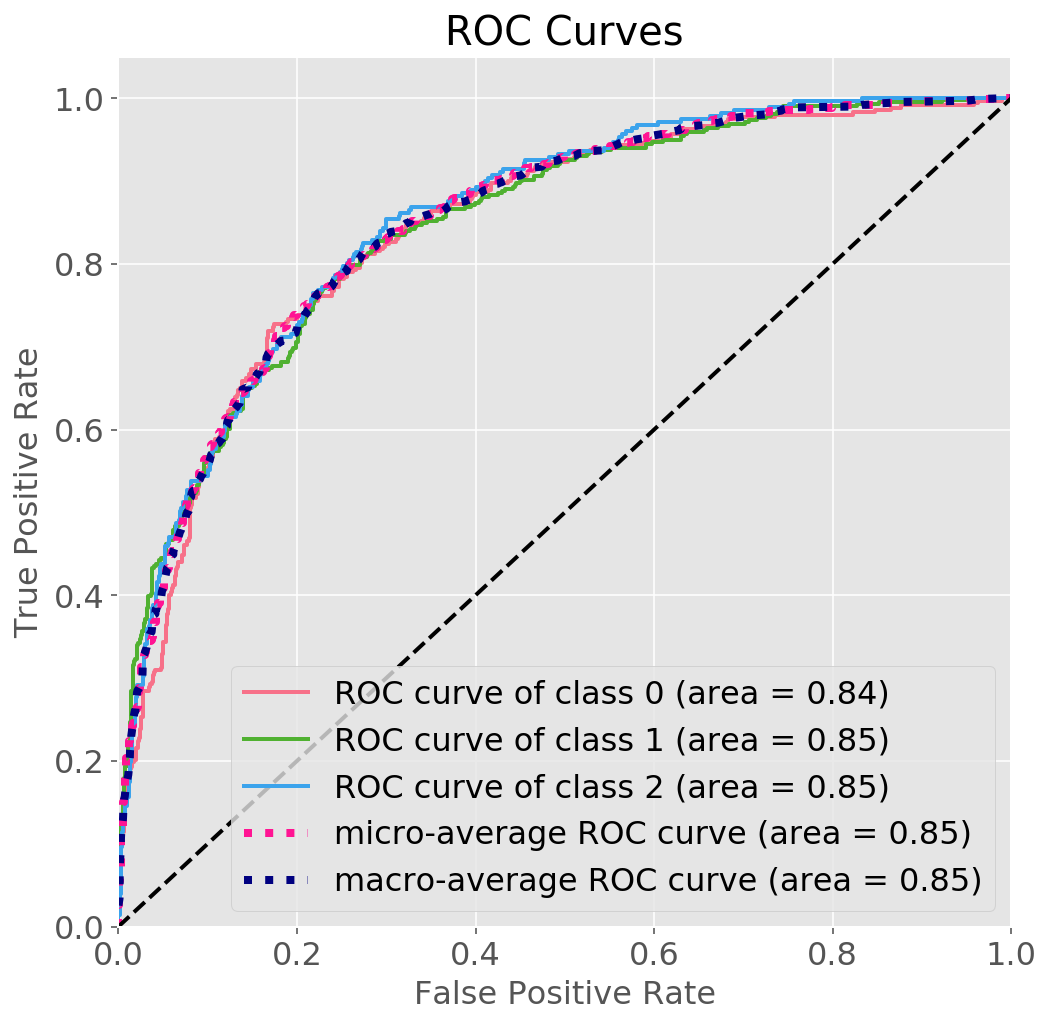

In [215]:
skplt.metrics.plot_roc(y_test, probabilities, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(8,8), cmap=cmap)
plt.show()

In [216]:
print('Area under ROC curve (ROC-AUC):')
for i, class_ in enumerate(lreg_final.classes_):
    print('Class {}:'.format(class_), round(roc_auc_score(y_bin[:,i],lreg_final.predict_proba(X_test)[:,i]),2))

Area under ROC curve (ROC-AUC):
Class 0: 0.84
Class 1: 0.85
Class 2: 0.85


In [217]:
skplt.metrics.roc_curve(y_test==0, probabilities[:,0])

(array([0.        , 0.        , 0.        , 0.00143062, 0.00143062,
        0.00286123, 0.00286123, 0.00572246, 0.00572246, 0.00715308,
        0.00715308, 0.00858369, 0.00858369, 0.01144492, 0.01144492,
        0.01287554, 0.01287554, 0.01430615, 0.01430615, 0.01573677,
        0.01573677, 0.01716738, 0.01716738, 0.02002861, 0.02002861,
        0.02145923, 0.02145923, 0.02288984, 0.02288984, 0.02432046,
        0.02432046, 0.02575107, 0.02575107, 0.02718169, 0.02718169,
        0.03433476, 0.03433476, 0.03576538, 0.03576538, 0.03719599,
        0.03719599, 0.03862661, 0.03862661, 0.04005722, 0.04005722,
        0.04148784, 0.04148784, 0.0472103 , 0.0472103 , 0.04864092,
        0.04864092, 0.05007153, 0.05007153, 0.05293276, 0.05293276,
        0.05436338, 0.05436338, 0.05579399, 0.05579399, 0.05722461,
        0.05722461, 0.05865522, 0.05865522, 0.06008584, 0.06008584,
        0.06151645, 0.06151645, 0.06294707, 0.06294707, 0.06437768,
        0.06437768, 0.0658083 , 0.0658083 , 0.06